## About the Project

* Vesta Corporation provided the dataset for this competition. Vesta Corporation is the forerunner in guaranteed e-commerce payment solutions. Founded in 1995.
 
* In this competition, the aim is to benchmark machine learning models on a challenging large-scale dataset. 
* The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. 
* The machine learning model will alert the fraudulent transaction for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. 
* The training dataset consists of more than 400 features and 5.9 Million samples. This is supervised binary classification problem and goal is to predict if a credit card transaction is Fraud based on input features mentioned below

**Evaluation**
* The model is evaluated on AUC ROC score. The notebook will produce an output csv file with TransactionID and predicted probabilties on test set,  which will be automatically evaluted by Kaggle.

### Transaction Table 
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

<br>  **Categorical Features:**
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

### Identity Table 
* Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
* They're collected by Vesta’s fraud protection system and digital security partners.
* (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

<br> **Categorical Features:**
* DeviceType
* DeviceInfo
* id_12 - id_38



## Import Libraries

In [1]:
#Install latest version of the package as  the defualt version is not working fine
!pip install seaborn==0.11.0

     |████████████████████████████████| 283 kB 582 kB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

hypertools 0.6.2 requires scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.23.2 which is incompatible.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os, gc
print(os.listdir("../input"))

import seaborn as sns
sns.set_theme(style="darkgrid")

import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

#setting for plot fonts 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


['ieee-fraud-detection']
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


## CONSTANTS

In [3]:
RANDOM_STATE = 42
DEBUG_MODE = False  # Load fewer samples to save time for quick testing
TARGET = 'isFraud'
SHOW_GRAPHS = True

## Read Data
https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-586800



In [4]:
%%time

# Load fewer samples to save time for quick testing
if DEBUG_MODE:
    nrows = 50000
else:
    nrows = None
        
data_path = '/kaggle/input/ieee-fraud-detection/'
train_identity = pd.read_csv(os.path.join(data_path, 'train_identity.csv'))
train_transaction = pd.read_csv(os.path.join(data_path, 'train_transaction.csv'), nrows = nrows)
test_identity = pd.read_csv(os.path.join(data_path, 'test_identity.csv'))
test_transaction =pd.read_csv(os.path.join(data_path, 'test_transaction.csv'), nrows = nrows)
print('Train Identity Data - rows:', train_identity.shape[0], 
      'columns:', train_identity.shape[1])
print('Train Transaction Data - rows:', train_transaction.shape[0], 
      'columns:', train_transaction.shape[1])
print('Test Identity Data - rows:', test_identity.shape[0], 
      'columns:', test_identity.shape[1])
print('Test Transaction Data - rows:', test_transaction.shape[0], 
      'columns:', test_transaction.shape[1])

Train Identity Data - rows: 144233 columns: 41
Train Transaction Data - rows: 590540 columns: 394
Test Identity Data - rows: 141907 columns: 41
Test Transaction Data - rows: 506691 columns: 393
CPU times: user 55.7 s, sys: 7.04 s, total: 1min 2s
Wall time: 1min 2s


### Transaction Data



In [5]:
train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4  ... V290 V291 V292  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2  ...  1.0  1.0  1.0   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0  ...  1.0  1.0  1.0   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0  ...  1.0  1.0  1.0   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0  ...  1.0  1.0  1.0   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  ...  1.0  1.0  1.0   

  V293  V294  V295  V296  V297  V298  V299  V300  V301  V302  V303  V304  \
0  0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3  1.0  38.0  24.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   

   V305  V306    V307   V308  V309   V310  V311   V312  V313  V314  V315  \
0   1.0   0.0   117.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   
1   1.0   0.0     0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   
2   1.0   0.0     0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   
3   1.0  50.0  1758.0  925.0   0.0  354.0   0.0  135.0   0.0   0.0   0.0   
4   1.0   0.0     0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   

   V316    V317   V318  V319  V320  V321  V322  V323  V324  V325  V326  V327  \
0   0.0   117.0    0.0   0.0   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   
1   0.0     0.0    0.0   0.0   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   
2   0.0     0.0    0.0   0.0   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   
3  50.0  1404.0  790.0   0.0   0.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   
4   0.0     0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   V328  V329  V330  V331  V332  V333  V334  V335  V336  V337  V338  V339  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   N

In [6]:

def column_properties(df):
    columns_prop = pd.DataFrame()
    columns_prop['column'] = df.columns.tolist()
    columns_prop['count_non_null'] = df.count().values
    columns_prop['count_null'] = df.isnull().sum().values
    columns_prop['perc_null'] = columns_prop['count_null'] * 100 / df.shape[0]

    #using df.nunique() is memory intensive and slow resulting in kernal death
    unique_list = []
    for col in df.columns.tolist():
        unique_list.append(df[col].value_counts().shape[0])
    columns_prop['count_unique'] =  unique_list
    
    columns_prop['dtype'] = df.dtypes.values
    columns_prop.set_index('column', inplace = True)
    return columns_prop


In [7]:
column_properties(train_transaction).T

column         TransactionID isFraud TransactionDT TransactionAmt ProductCD  \
count_non_null        590540  590540        590540         590540    590540   
count_null                 0       0             0              0         0   
perc_null                  0       0             0              0         0   
count_unique          590540       2        573349          20902         5   
dtype                  int64   int64         int64        float64    object   

column           card1    card2     card3     card4     card5     card6  \
count_non_null  590540   581607    588975    588963    586281    588969   
count_null           0     8933      1565      1577      4259      1571   
perc_null            0  1.51268  0.265012  0.267044  0.721204  0.266028   
count_unique     13553      500       114         4       119         4   
dtype            int64  float64   float64    object   float64    object   

column            addr1    addr2    dist1    dist2 P_emaildomain  \
count_non_null   524834   524834   238269    37627        496084   
count_null        65706    65706   352271   552913         94456   
perc_null       11.1264  11.1264  59.6524  93.6284       15.9949   
count_unique        332       74     2651     1751            59   
dtype           float64  float64  float64  float64        object   

column         R_emaildomain       C1       C2       C3       C4       C5  \
count_non_null        137291   590540   590540   590540   590540   590540   
count_null            453249        0        0        0        0        0   
perc_null            76.7516        0        0        0        0        0   
count_unique              60     1657     1216       27     1260      319   
dtype                 object  float64  float64  float64  float64  float64   

column               C6       C7       C8       C9      C10      C11      C12  \
count_non_null   590540   590540   590540   590540   590540   590540   590540   
count_null            0        0        0        0        0        0        0   
perc_null             0        0        0        0        0        0        0   
count_unique       1328     1103     1253      205     1231     1476     1199   
dtype           float64  float64  float64  float64  float64  float64  float64   

column              C13      C14        D1       D2       D3       D4  \
count_non_null   590540   590540    589271   309743   327662   421618   
count_null            0        0      1269   280797   262878   168922   
perc_null             0        0  0.214888  47.5492  44.5149  28.6047   
count_unique       1597     1108       641      641      649      808   
dtype           float64  float64   float64  float64  float64  float64   

column               D5       D6       D7       D8       D9      D10      D11  \
count_non_null   280699    73187    38917    74926    74926   514518   311253   
count_null       309841   517353   551623   515614   515614    76022   279287   
perc_null       52.4674  87.6068  93.4099  87.3123  87.3123  12.8733  47.2935   
count_unique        688      829      597    12353       24      818      676   
dtype           float64  float64  float64  float64  float64  float64  float64   

column              D12      D13      D14      D15       M1       M2       M3  \
count_non_null    64717    61952    62187   501427   319440   319440   319440   
count_null       525823   528588   528353    89113   271100   271100   271100   
perc_null        89.041  89.5093  89.4695  15.0901  45.9071  45.9071  45.9071   
count_unique        635      577      802      859        2        2        2   
dtype           float64  float64  float64  float64   object   object   object   

column               M4  ...        V290        V291        V292        V293  \
count_non_null   309096  ...      590528      590528      590528      590528   
count_null       281444  ...          12          12          12          12   
perc_null       47.6588  ...  0.00203204  0.00203204  0.002032

### Identity Data
* Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
* As we can see that the columns name for training set and test are not same,we will correct columns names of test set using traning column name

In [8]:
train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0    New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0    New  NotFound  166.0    NaN   
2    0.0    0.0  100.0  NotFound   52.0    NaN  Found     Found  121.0    NaN   
3    NaN    NaN  100.0  NotFound   52.0    NaN    New  NotFound  225.0    NaN   
4    0.0    0.0  100.0  NotFound    NaN -300.0  Found     Found  166.0   15.0   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  542.0  144.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  621.0  500.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
2  410.0  142.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
3  176.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
4  529.0  575.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   

      id_29             id_30                id_31  id_32      id_33  \
0  NotFound       Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound        iOS 11.1.2   mobile safari 11.0   32.0   1334x750   
2     Found               NaN          chrome 62.0    NaN        NaN   
3  NotFound               NaN          chrome 62.0    NaN        NaN   
4     Found  Mac OS X 10_11_6          chrome 62.0   24.0   1280x800   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   
2             NaN     F     F     T     T    desktop   
3             NaN     F     F     T     T    desktop   
4  match_status:2     T     F     T     T    desktop   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device  
2                        Windows  
3                            NaN  
4                          MacOS

In [9]:
test_identity.head()

TransactionID  id-01     id-02  id-03  id-04  id-05  id-06  id-07  id-08  \
0        3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN    NaN   
1        3663588    0.0    3579.0    0.0    0.0    0.0    0.0    NaN    NaN   
2        3663597   -5.0  185210.0    NaN    NaN    1.0    0.0    NaN    NaN   
3        3663601  -45.0  252944.0    0.0    0.0    0.0    0.0    NaN    NaN   
4        3663602  -95.0  328680.0    NaN    NaN    7.0  -33.0    NaN    NaN   

   id-09  id-10  id-11     id-12  id-13  id-14  id-15     id-16  id-17  id-18  \
0    NaN    NaN  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0   
1    0.0    0.0  100.0     Found    NaN -300.0  Found     Found  166.0    NaN   
2    NaN    NaN  100.0  NotFound   52.0 -360.0    New  NotFound  225.0    NaN   
3    0.0    0.0  100.0  NotFound   27.0    NaN  Found     Found  225.0   15.0   
4    NaN    NaN  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0   

   id-19  id-20  id-21  id-22 id-23  id-24  id-25  id-26 id-27  id-28  \
0  427.0  563.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  542.0  368.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
2  271.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
3  427.0  563.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
4  567.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   

      id-29          id-30                    id-31  id-32     id-33  \
0  NotFound            NaN  chrome 67.0 for android    NaN       NaN   
1     Found  Android 6.0.1  chrome 67.0 for android   24.0  1280x720   
2  NotFound            NaN       ie 11.0 for tablet    NaN       NaN   
3     Found            NaN  chrome 67.0 for android    NaN       NaN   
4  NotFound            NaN  chrome 67.0 for android    NaN       NaN   

            id-34 id-35 id-36 id-37 id-38 DeviceType  \
0             NaN     F     F     T     F     mobile   
1  match_status:2     T     F     T     T     mobile   
2             NaN     F     T     T     F    desktop   
3             NaN     F     F     T     F     mobile   
4             NaN     F     F     T     F     mobile   

                    DeviceInfo  
0  MYA-L13 Build/HUAWEIMYA-L13  
1         LGLS676 Build/MXB48T  
2                  Trident/7.0  
3  MYA-L13 Build/HUAWEIMYA-L13  
4         SM-G9650 Build/R16NW

In [10]:
# the columns name for training set and test are not same,we will correct columns names of test set using traning column name
identity_col_names =  train_identity.columns.tolist()
test_identity.columns = identity_col_names
print(test_identity.columns.tolist())

['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [11]:
test_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN    NaN   
1        3663588    0.0    3579.0    0.0    0.0    0.0    0.0    NaN    NaN   
2        3663597   -5.0  185210.0    NaN    NaN    1.0    0.0    NaN    NaN   
3        3663601  -45.0  252944.0    0.0    0.0    0.0    0.0    NaN    NaN   
4        3663602  -95.0  328680.0    NaN    NaN    7.0  -33.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0   
1    0.0    0.0  100.0     Found    NaN -300.0  Found     Found  166.0    NaN   
2    NaN    NaN  100.0  NotFound   52.0 -360.0    New  NotFound  225.0    NaN   
3    0.0    0.0  100.0  NotFound   27.0    NaN  Found     Found  225.0   15.0   
4    NaN    NaN  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  427.0  563.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  542.0  368.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
2  271.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
3  427.0  563.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   
4  567.0  507.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   

      id_29          id_30                    id_31  id_32     id_33  \
0  NotFound            NaN  chrome 67.0 for android    NaN       NaN   
1     Found  Android 6.0.1  chrome 67.0 for android   24.0  1280x720   
2  NotFound            NaN       ie 11.0 for tablet    NaN       NaN   
3     Found            NaN  chrome 67.0 for android    NaN       NaN   
4  NotFound            NaN  chrome 67.0 for android    NaN       NaN   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0             NaN     F     F     T     F     mobile   
1  match_status:2     T     F     T     T     mobile   
2             NaN     F     T     T     F    desktop   
3             NaN     F     F     T     F     mobile   
4             NaN     F     F     T     F     mobile   

                    DeviceInfo  
0  MYA-L13 Build/HUAWEIMYA-L13  
1         LGLS676 Build/MXB48T  
2                  Trident/7.0  
3  MYA-L13 Build/HUAWEIMYA-L13  
4         SM-G9650 Build/R16NW

In [12]:
column_properties(train_identity).T

column         TransactionID    id_01    id_02    id_03    id_04    id_05  \
count_non_null        144233   144233   140872    66324    66324   136865   
count_null                 0        0     3361    77909    77909     7368   
perc_null                  0        0  2.33026  54.0161  54.0161   5.1084   
count_unique          144233       77   115655       24       15       93   
dtype                  int64  float64  float64  float64  float64  float64   

column            id_06    id_07    id_08    id_09    id_10    id_11   id_12  \
count_non_null   136865     5155     5155    74926    74926   140978  144233   
count_null         7368   139078   139078    69307    69307     3255       0   
perc_null        5.1084  96.4259  96.4259  48.0521  48.0521  2.25677       0   
count_unique        101       84       94       46       62      365       2   
dtype           float64  float64  float64  float64  float64  float64  object   

column            id_13    id_14    id_15    id_16    id_17    id_18    id_19  \
count_non_null   127320    80044   140985   129340   139369    45113   139318   
count_null        16913    64189     3248    14893     4864    99120     4915   
perc_null       11.7262  44.5037  2.25191  10.3257  3.37232  68.7221  3.40768   
count_unique         54       25        3        2      104       18      522   
dtype           float64  float64   object   object  float64  float64  float64   

column            id_20    id_21    id_22    id_23    id_24    id_25    id_26  \
count_non_null   139261     5159     5169     5169     4747     5132     5163   
count_null         4972   139074   139064   139064   139486   139101   139070   
perc_null        3.4472  96.4231  96.4162  96.4162  96.7088  96.4419  96.4204   
count_unique        394      490       25        3       12      341       95   
dtype           float64  float64  float64   object  float64  float64  float64   

column            id_27    id_28    id_29    id_30    id_31    id_32    id_33  \
count_non_null     5169   140978   140978    77565   140282    77586    73289   
count_null       139064     3255     3255    66668     3951    66647    70944   
perc_null       96.4162  2.25677  2.25677  46.2224  2.73932  46.2079  49.1871   
count_unique          2        2        2       75      130        4      260   
dtype            object   object   object   object   object  float64   object   

column           id_34    id_35    id_36    id_37    id_38 DeviceType  \
count_non_null   77805   140985   140985   140985   140985     140810   
count_null       66428     3248     3248     3248     3248       3423   
perc_null       46.056  2.25191  2.25191  2.25191  2.25191    2.37324   
count_unique         4        2        2        2        2          2   
dtype           object   object   object   object   object     object   

column         DeviceInfo  
count_non_null     118666  
count_null          25567  
perc_null         17.7262  
count_unique         1786  
dtype              object

## Merge Data
Make a join between transaction data and identity data which are connected by key 'TransactionID

In [13]:
%%time
train = pd.merge(train_transaction, train_identity, on= 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on= 'TransactionID', how = 'left')
del train_transaction, train_identity, test_transaction, test_identity
gc.collect()
train.shape

CPU times: user 11 s, sys: 8.8 s, total: 19.8 s
Wall time: 19.8 s


(590540, 434)

## Missing Values
There are 214 columns with more than 50% of missing values. Display all such columns and their properties



In [14]:
%%time
col_prop_trn = column_properties(train)
col_prop_tst = column_properties(test)

#Find number of  columns with more that 50% missing values
missing_cols_50 = col_prop_trn[col_prop_trn['perc_null'] > 50]
print('Count of columns with more than 50% missing values {}'.format(missing_cols_50.shape[0]))
missing_cols_50.sort_values(by = 'perc_null', ascending = False).T


Count of columns with more than 50% missing values 214
CPU times: user 22.1 s, sys: 4.12 s, total: 26.2 s
Wall time: 26.2 s


column            id_24    id_25    id_08    id_07    id_21    id_26    id_23  \
count_non_null     4747     5132     5155     5155     5159     5163     5169   
count_null       585793   585408   585385   585385   585381   585377   585371   
perc_null       99.1962   99.131  99.1271  99.1271  99.1264  99.1257  99.1247   
count_unique         12      341       94       84      490       95        3   
dtype           float64  float64  float64  float64  float64  float64   object   

column            id_22    id_27    dist2       D7    id_18      D13      D14  \
count_non_null     5169     5169    37627    38917    45113    61952    62187   
count_null       585371   585371   552913   551623   545427   528588   528353   
perc_null       99.1247  99.1247  93.6284  93.4099  92.3607  89.5093  89.4695   
count_unique         25        2     1751      597       18      577      802   
dtype           float64   object  float64  float64  float64  float64  float64   

column              D12    id_03    id_04       D6    id_33       D8       D9  \
count_non_null    64717    66324    66324    73187    73289    74926    74926   
count_null       525823   524216   524216   517353   517251   515614   515614   
perc_null        89.041  88.7689  88.7689  87.6068  87.5895  87.3123  87.3123   
count_unique        635       24       15      829      260    12353       24   
dtype           float64  float64  float64  float64   object  float64  float64   

column            id_09    id_10    id_30    id_32    id_34    id_14     V142  \
count_non_null    74926    74926    77565    77586    77805    80044    81945   
count_null       515614   515614   512975   512954   512735   510496   508595   
perc_null       87.3123  87.3123  86.8654  86.8619  86.8248  86.4456  86.1237   
count_unique         46       62       75        4        4       25       10   
dtype           float64  float64   object  float64   object  float64  float64   

column             V157     V163     V162     V161     V138     V158     V155  \
count_non_null    81945    81945    81945    81945    81945    81945    81945   
count_null       508595   508595   508595   508595   508595   508595   508595   
perc_null       86.1237  86.1237  86.1237  86.1237  86.1237  86.1237  86.1237   
count_unique         25      106      185       79       23       25       25   
dtype           float64  float64  float64  float64  float64  float64  float64   

column             V156     V141     V154     V153     V149     V148     V139  \
count_non_null    81945    81945    81945    81945    81945    81945    81945   
count_null       508595   508595   508595   508595   508595   508595   508595   
perc_null       86.1237  86.1237  86.1237  86.1237  86.1237  86.1237  86.1237   
count_unique         25        6       19       19       21       21       34   
dtype           float64  float64  float64  float64  float64  float64  float64   

column             V146     V140     V147     V160     V166     V164     V159  \
count_non_null    81945    81945    81945    81951    81951    81951    81951   
count_null       508595   508595   508595   508589   508589   508589   508589   
perc_null       86.1237  86.1237  86.1237  86.1227  86.1227  86.1227  86.1227   
count_unique         25       34       27     9621      987     1978     6663   
dtype           float64  float64  float64  float64  float64  float64  float64   

column             V152  ...     V170     V175     V174     V171     V189  \
count_non_null    81951  ...   139819   139819   139819   139819   139819   
count_null       508589  ...   450721   450721   450721   450721   450721   
perc_null       86.1227  ...  76.3235  76.3235  76.3235  76.3235  76.3235   
count_unique         39  ...       49       15        9       62       31   
dtype           float64  ...  float64  float64  float64  float64  float64   

column             V209     V208     V201     V194     V200     V169     V198  \
count_non_null   139819   139819   139819   139

* x-axis represnt the perecntage of of missing values
* y-axis represent the count of such columns
1. There are around 115 columns which have missing value in range of 0 to 10 %
1. There are around 125 columns which have missing value 70 to 80 %

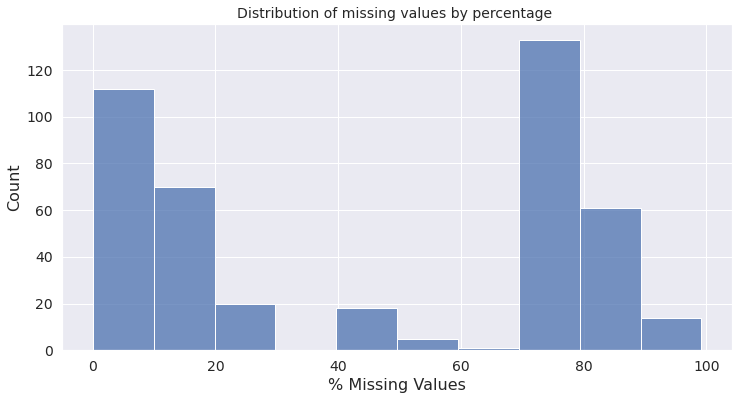

In [15]:

plt.figure(figsize= (12,6))
s = sns.histplot(col_prop_trn['perc_null'])
s.set_title('Distribution of missing values by percentage ')
s.set(xlabel = '% Missing Values')
plt.show()

> ## Target Value
3.5 % of transactions are fraud which indicates that its imbalanced dataset

In [16]:
def get_target_dist(train):
    df = train.groupby(TARGET).agg({TARGET:['count'] })
    df.columns = ['count']

    df['percent'] = df['count'] *100 / df['count'].sum()
    df['percent'] = df['percent'].round(2)
    return df

In [17]:
target_dist = get_target_dist(train)
target_dist

count  percent
isFraud                 
0        569877     96.5
1         20663      3.5

In [18]:
def plot_taget_dist(target_df):
    fig, (ax1, ax2)  =  plt.subplots(ncols = 2, figsize = (12, 6))
    s = sns.barplot(ax = ax1, x = target_df.index, y = "count", data = target_df)
    s.set_title('Target Value Count')
    s = sns.barplot(ax = ax2, x = target_df.index, y = "percent", data =target_df)
    s.set_title('Target Value Distribution')

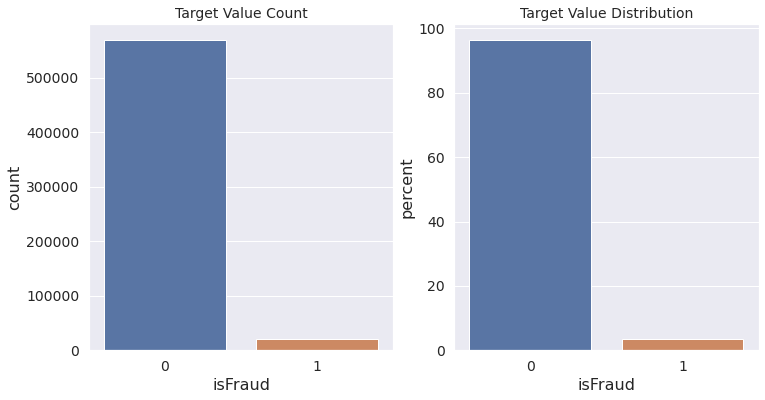

In [19]:
plot_taget_dist(target_dist)

## Categorical Columns
Create list of categorical columns based on decsription below
<br>https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-586800

In [20]:




cat_cols = ['DeviceType', 'DeviceInfo', 'ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']
cat_cols +=  ['M' + str(i) for i in range(1,10)]
cat_cols += ['card' + str(i) for i in range(1,7)]
cat_cols += ['id_' + str(i) for i in range(12,39)]
column_properties(train[cat_cols]).T


column         DeviceType DeviceInfo ProductCD    addr1    addr2  \
count_non_null     140810     118666    590540   524834   524834   
count_null         449730     471874         0    65706    65706   
perc_null         76.1557    79.9055         0  11.1264  11.1264   
count_unique            2       1786         5      332       74   
dtype              object     object    object  float64  float64   

column         P_emaildomain R_emaildomain       M1       M2       M3  \
count_non_null        496084        137291   319440   319440   319440   
count_null             94456        453249   271100   271100   271100   
perc_null            15.9949       76.7516  45.9071  45.9071  45.9071   
count_unique              59            60        2        2        2   
dtype                 object        object   object   object   object   

column               M4       M5       M6       M7       M8       M9   card1  \
count_non_null   309096   240058   421180   244275   244288   244288  590540   
count_null       281444   350482   169360   346265   346252   346252       0   
perc_null       47.6588  59.3494  28.6788  58.6353  58.6331  58.6331       0   
count_unique          3        2        2        2        2        2   13553   
dtype            object   object   object   object   object   object   int64   

column            card2     card3     card4     card5     card6    id_12  \
count_non_null   581607    588975    588963    586281    588969   144233   
count_null         8933      1565      1577      4259      1571   446307   
perc_null       1.51268  0.265012  0.267044  0.721204  0.266028  75.5761   
count_unique        500       114         4       119         4        2   
dtype           float64   float64    object   float64    object   object   

column            id_13    id_14    id_15   id_16    id_17    id_18    id_19  \
count_non_null   127320    80044   140985  129340   139369    45113   139318   
count_null       463220   510496   449555  461200   451171   545427   451222   
perc_null       78.4401  86.4456  76.1261  78.098  76.3997  92.3607  76.4084   
count_unique         54       25        3       2      104       18      522   
dtype           float64  float64   object  object  float64  float64  float64   

column            id_20    id_21    id_22    id_23    id_24    id_25    id_26  \
count_non_null   139261     5159     5169     5169     4747     5132     5163   
count_null       451279   585381   585371   585371   585793   585408   585377   
perc_null        76.418  99.1264  99.1247  99.1247  99.1962   99.131  99.1257   
count_unique        394      490       25        3       12      341       95   
dtype           float64  float64  float64   object  float64  float64  float64   

column            id_27    id_28    id_29    id_30    id_31    id_32    id_33  \
count_non_null     5169   140978   140978    77565   140282    77586    73289   
count_null       585371   449562   449562   512975   450258   512954   517251   
perc_null       99.1247  76.1273  76.1273  86.8654  76.2451  86.8619  87.5895   
count_unique          2        2        2       75      130        4      260   
dtype            object   object   object   object   object  float64   object   

column            id_34    id_35    id_36    id_37    id_38  
count_non_null    77805   140985   140985   140985   140985  
count_null       512735   449555   449555   449555   449555  
perc_null       86.8248  76.1261  76.1261  76.1261  76.1261  
count_unique          4        2        2        2        2  
dtype            object   object   object   object   object

In [21]:
train[cat_cols].head()

DeviceType                     DeviceInfo ProductCD  addr1  addr2  \
0        NaN                            NaN         W  315.0   87.0   
1        NaN                            NaN         W  325.0   87.0   
2        NaN                            NaN         W  330.0   87.0   
3        NaN                            NaN         W  476.0   87.0   
4     mobile  SAMSUNG SM-G892A Build/NRD90M         H  420.0   87.0   

  P_emaildomain R_emaildomain   M1   M2   M3   M4   M5   M6   M7   M8   M9  \
0           NaN           NaN    T    T    T   M2    F    T  NaN  NaN  NaN   
1     gmail.com           NaN  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN   
2   outlook.com           NaN    T    T    T   M0    F    F    F    F    F   
3     yahoo.com           NaN  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN   
4     gmail.com           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   card1  card2  card3       card4  card5   card6     id_12  id_13  id_14  \
0  13926    NaN  150.0    discover  142.0  credit       NaN    NaN    NaN   
1   2755  404.0  150.0  mastercard  102.0  credit       NaN    NaN    NaN   
2   4663  490.0  150.0        visa  166.0   debit       NaN    NaN    NaN   
3  18132  567.0  150.0  mastercard  117.0   debit       NaN    NaN    NaN   
4   4497  514.0  150.0  mastercard  102.0  credit  NotFound    NaN -480.0   

  id_15     id_16  id_17  id_18  id_19  id_20  id_21  id_22 id_23  id_24  \
0   NaN       NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN    NaN   
1   NaN       NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN    NaN   
2   NaN       NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN    NaN   
3   NaN       NaN    NaN    NaN    NaN    NaN    NaN    NaN   NaN    NaN   
4   New  NotFound  166.0    NaN  542.0  144.0    NaN    NaN   NaN    NaN   

   id_25  id_26 id_27 id_28     id_29        id_30                id_31  \
0    NaN    NaN   NaN   NaN       NaN          NaN                  NaN   
1    NaN    NaN   NaN   NaN       NaN          NaN                  NaN   
2    NaN    NaN   NaN   NaN       NaN          NaN                  NaN   
3    NaN    NaN   NaN   NaN       NaN          NaN                  NaN   
4    NaN    NaN   NaN   New  NotFound  Android 7.0  samsung browser 6.2   

   id_32      id_33           id_34 id_35 id_36 id_37 id_38  
0    NaN        NaN             NaN   NaN   NaN   NaN   NaN  
1    NaN        NaN             NaN   NaN   NaN   NaN   NaN  
2    NaN        NaN             NaN   NaN   NaN   NaN   NaN  
3    NaN        NaN             NaN   NaN   NaN   NaN   NaN  
4   32.0  2220x1080  match_status:2     T     F     T     T

## Numeric Columns
* From list of all columns remove categorical columns, Target Value, and ID, this will give us numerical columns
* Display the statistical properties of numeric columns

In [22]:
%%time


all_cols = train.columns.tolist()
num_cols = [x for x in all_cols if x not in cat_cols]

num_cols.remove('TransactionID')
num_cols.remove(TARGET)
train[num_cols].describe()

CPU times: user 8.96 s, sys: 1.33 s, total: 10.3 s
Wall time: 10.3 s


TransactionDT  TransactionAmt          dist1         dist2  \
count   5.905400e+05   590540.000000  238269.000000  37627.000000   
mean    7.372311e+06      135.027176     118.502180    231.855423   
std     4.617224e+06      239.162522     371.872026    529.053494   
min     8.640000e+04        0.251000       0.000000      0.000000   
25%     3.027058e+06       43.321000       3.000000      7.000000   
50%     7.306528e+06       68.769000       8.000000     37.000000   
75%     1.124662e+07      125.000000      24.000000    206.000000   
max     1.581113e+07    31937.391000   10286.000000  11623.000000   

                  C1             C2             C3             C4  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean       14.092458      15.269734       0.005644       4.092185   
std       133.569018     154.668899       0.150536      68.848459   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         3.000000       3.000000       0.000000       0.000000   
max      4685.000000    5691.000000      26.000000    2253.000000   

                  C5             C6             C7             C8  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        5.571526       9.071082       2.848478       5.144574   
std        25.786976      71.508467      61.727304      95.378574   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       0.000000   
75%         1.000000       2.000000       0.000000       0.000000   
max       349.000000    2253.000000    2255.000000    3331.000000   

                  C9            C10            C11            C12  \
count  590540.000000  590540.000000  590540.000000  590540.000000   
mean        4.480240       5.240343      10.241521       4.076227   
std        16.674897      95.581443      94.336292      86.666218   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       0.000000   
50%         1.000000       0.000000       1.000000       0.000000   
75%         2.000000       0.000000       2.000000       0.000000   
max       210.000000    3257.000000    3188.000000    3188.000000   

                 C13            C14             D1             D2  \
count  590540.000000  590540.000000  589271.000000  309743.000000   
mean       32.539918       8.295215      94.347568     169.563231   
std       129.364844      49.544262     157.660387     177.315865   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000      26.000000   
50%         3.000000       1.000000       3.000000      97.000000   
75%        12.000000       2.000000     122.000000     276.000000   
max      2918.000000    1429.000000     640.000000     640.000000   

                  D3             D4             D5            D6  \
count  327662.000000  421618.000000  280699.000000  73187.000000   
mean       28.343348     140.002441      42.335965     69.805717   
std        62.384721     191.096774      89.000144    143.669253   
min         0.000000    -122.000000       0.000000    -83.000000   
25%         1.000000       0.000000       1.000000      0.000000   
50%         8.000000      26.000000      10.000000      0.000000   
75%        27.000000     253.000000      32.000000     40.000000   
max       819.000000     869.000000     819.000000    873.000000   

                 D7            D8            D9            D10            D11  \
count  38917.000000  74926.000000  74926.000000  514518.000000  311253.000000   
mean      41.638950    146.058108      0.561057     123.982137     146.621465   
std       99.743264    231.663840      0.

## EDA Categorical Features
EDA Categorical Features
Plot top 10 categories for category counts and percentage of fraud transactions. The header of each plot will also show percentage of missing values

1. DeviceType: Mobile devices has higher fraud rate at 10.17 % compared to desktop at 6.52 % though 76% of data is missing for this category.
1. DeviceInfo: Product C has high rate of fraud at 11.6% compared to 3.5% avergae rate for whole training dataset.
1. addr2: Category 65 though has only 82 records, but the fraud rate is abnormally high at 53%.
1. P_emaildomain: Purchaser email domain outlook.com has a relatively high fraud rate at 9.46%
1. R_emaildomain: Recipient email domain outlook.com has a relatively high fraud rate at 16.51% followed by gmail.com at 11.92%. Gmail is top category with count of 57K.
1. card4:Discover branded cards have highest fraud rate at 7.73% and american express has lowest at 2.87%
1. card6: credit cards have a higer rate of fraud at 6.68% compared to debit card at 2.43%
1. id_33: This feature represents screen resolution and there is one odd resolution 2208 X 1242 which has highest fraud rate at 9.84 and count of 4900. Quick google search reveals that this resolution corresponds to iPhone 6

In [23]:
def plot_categorical_data(col, data, top_n = 10, display_data = False ):
    
    # Prpare a dataframe for count and postive classs percent givel colums
    df_data = data[[col, TARGET]].copy()    
    df = df_data.groupby(col).agg({col:['count'], TARGET:['sum']})
    df.columns = ['count', 'fraud_count']

    df['fraud_perc'] = df['fraud_count'] * 100 / df['count']
    df['fraude_perc'] = df['fraud_perc'].round(2)
    
#    % missing values in the columns to be displayed in title
    null_perc = (df_data.shape[0]- df['count'].sum())  / df_data.shape[0]

    width = 18
    height = 6

#   select only top n categories
    df_disp = df.sort_values(by ='count', ascending= False).head(top_n )

    fig, (ax1, ax2)  =  plt.subplots(ncols = 2, figsize = (width,height))
    fig.suptitle('Plots for {} (Missing Values: {:.2%})'.format(col, null_perc))
    
#   Display Sort order should be by descending value of count
    plot_order = df_disp.sort_values(by='count', ascending=False).index.values

#   Display Bar chart for frequency count of top_n categories
    s = sns.barplot(ax = ax1,  y = df_disp.index, x = df_disp['count'], order=plot_order, orient = 'h'  )
    s.set_title('Count for {}'.format(col))
    
#   Display Bar chart for perecnt of positive class for top categories
    s = sns.barplot(ax = ax2,  y = df_disp.index, x = df_disp['fraud_perc'], order=plot_order , orient = 'h'    )
    s.set(xlabel='Fraud Percent')
    s.set_title('% Fraud {}'.format(col))
    plt.show()
    if display_data:
        return df

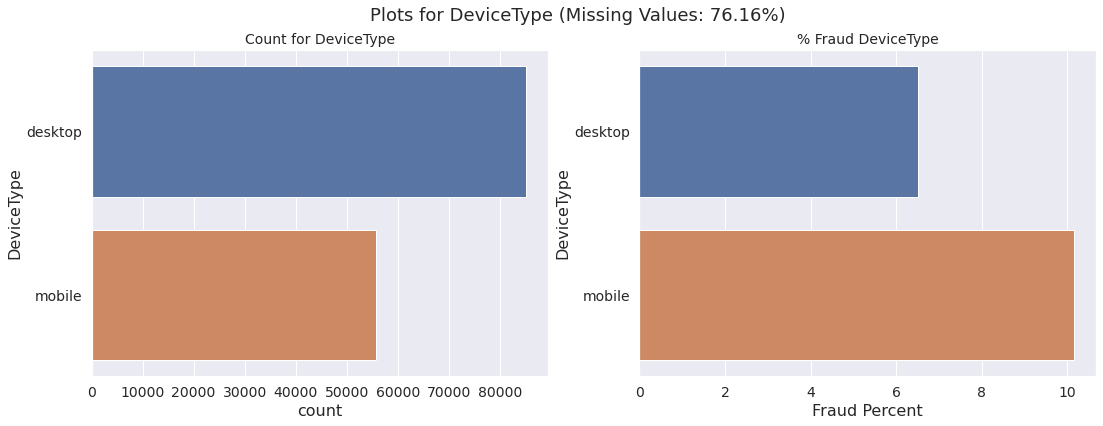

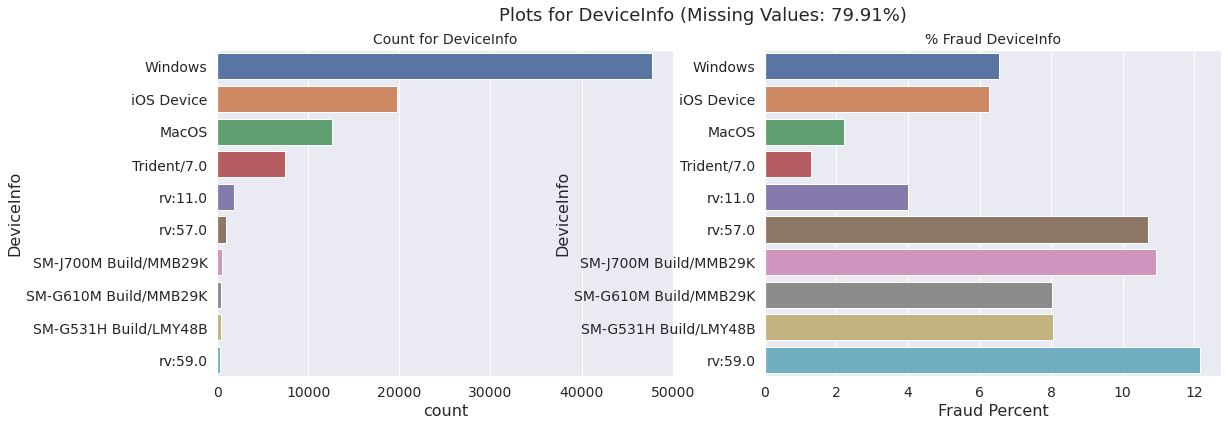

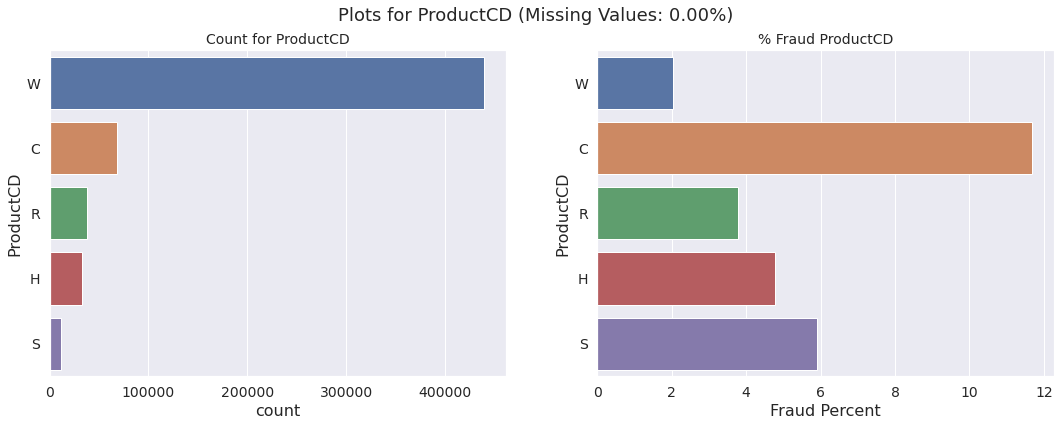

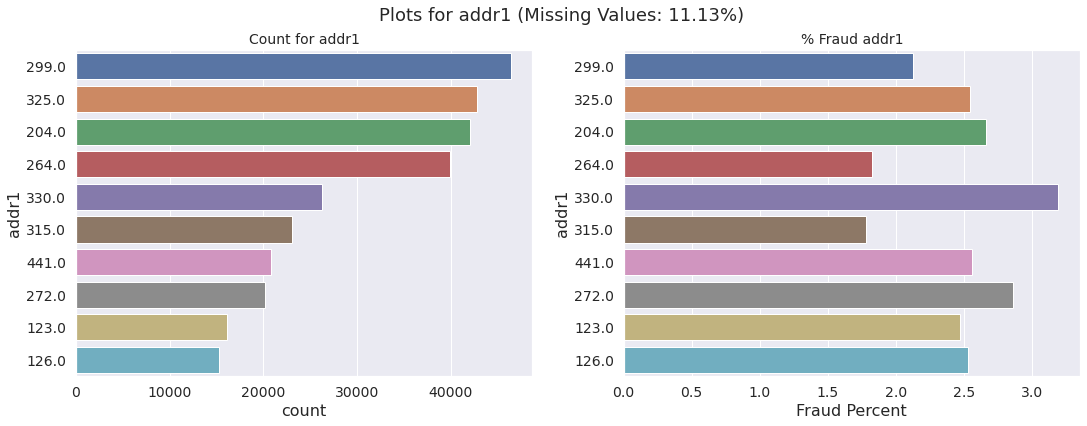

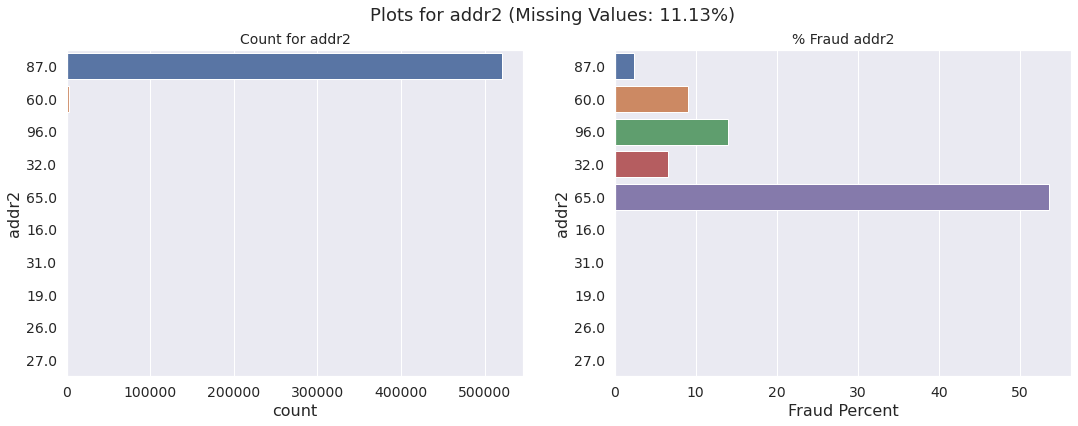

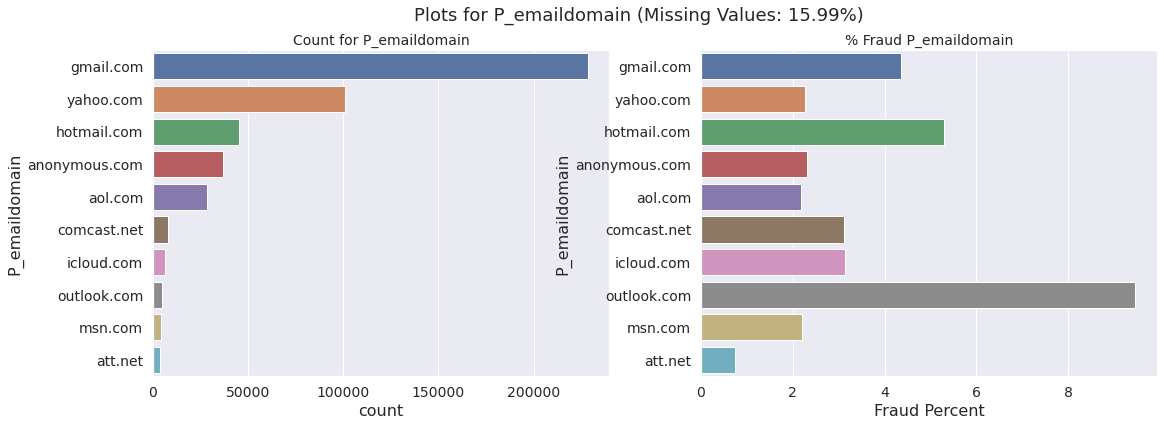

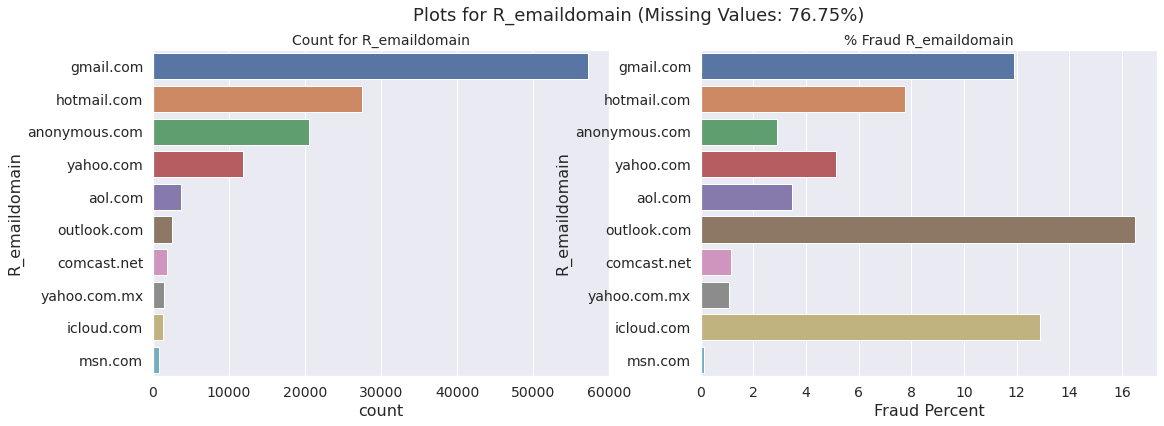

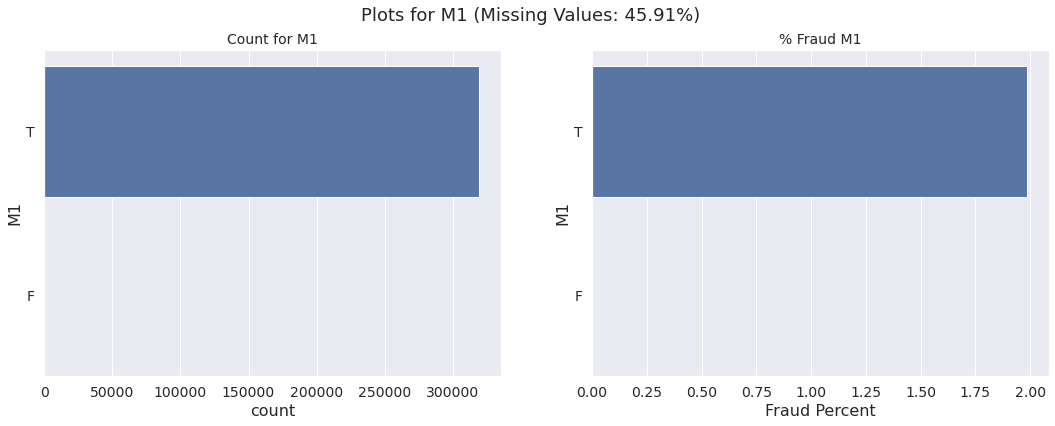

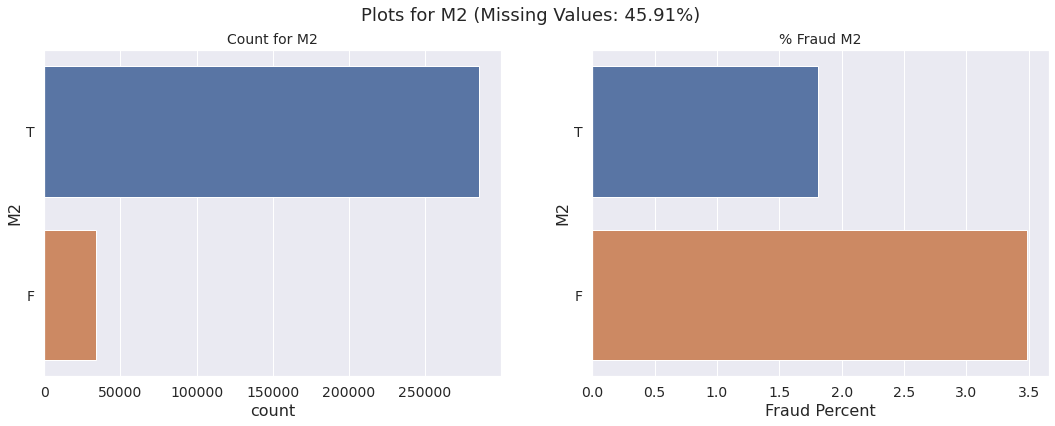

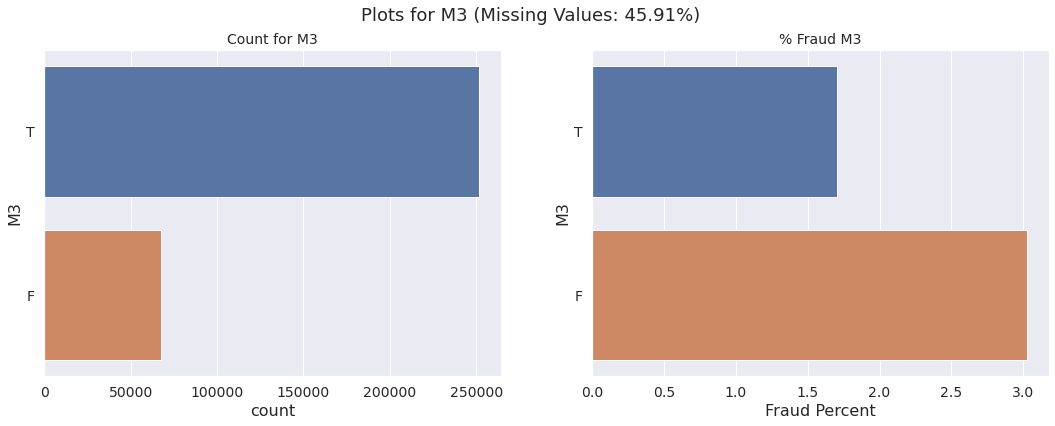

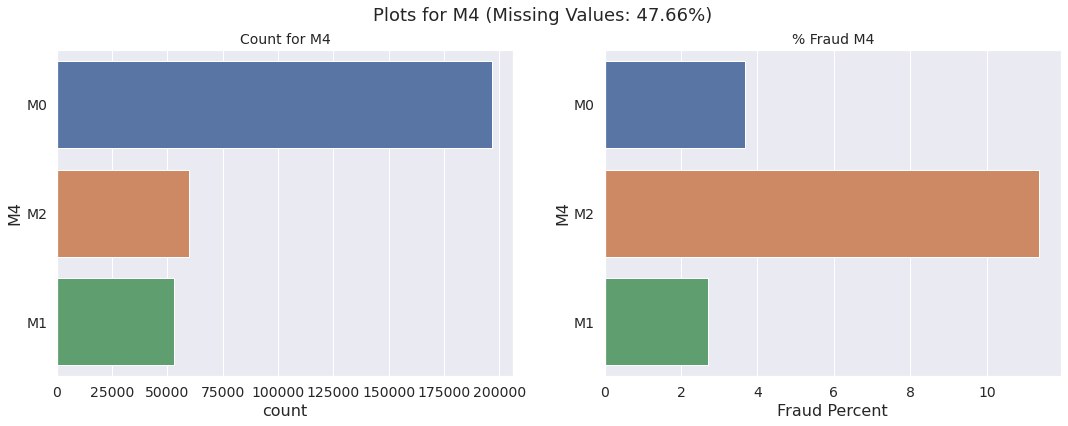

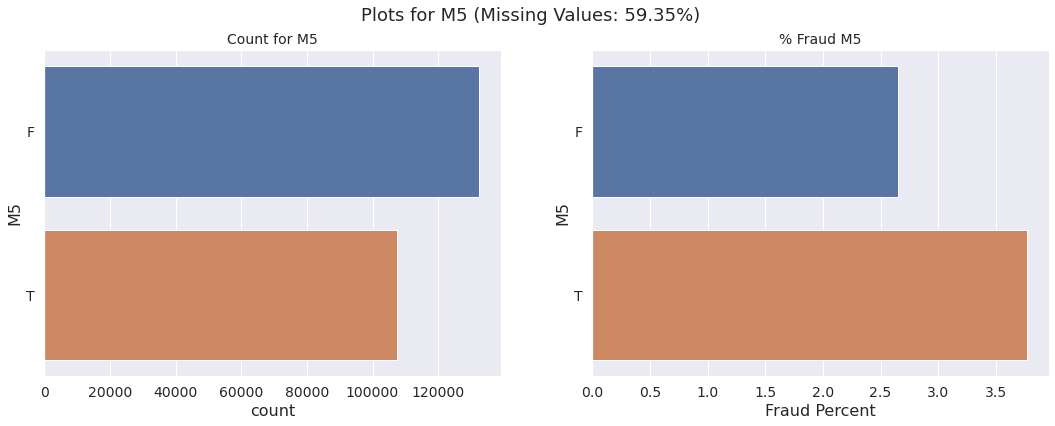

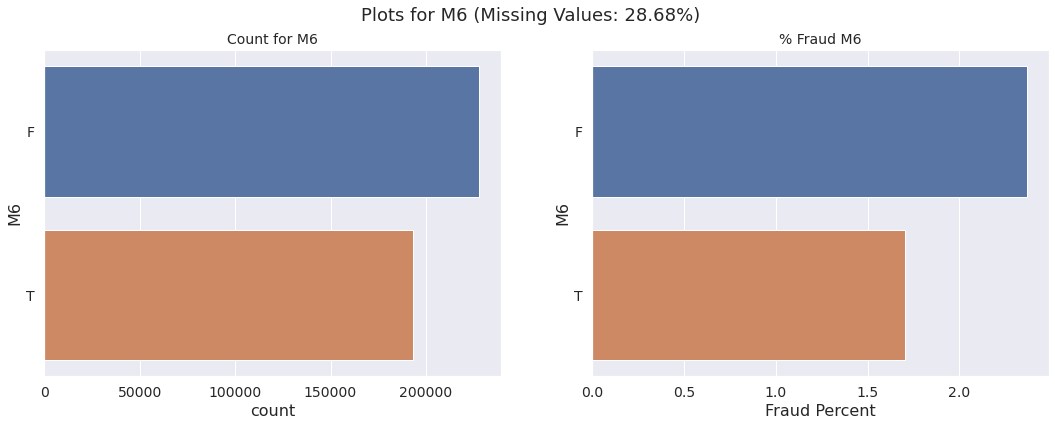

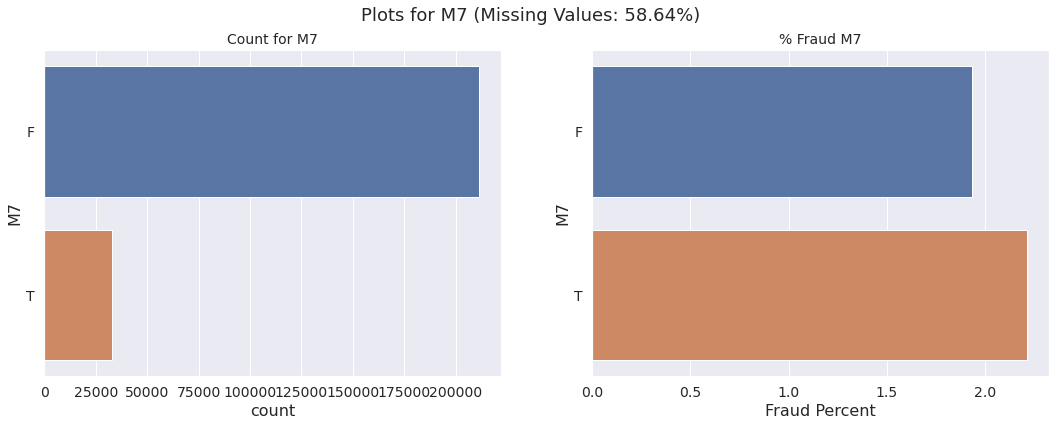

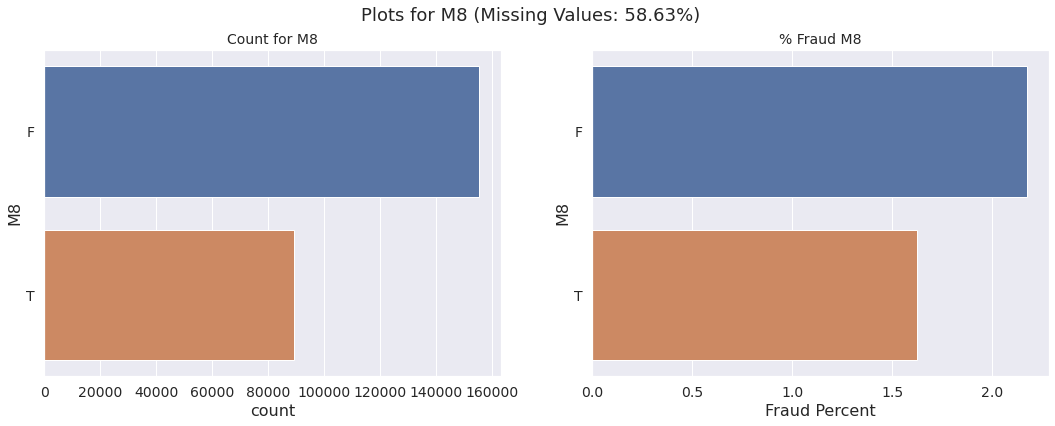

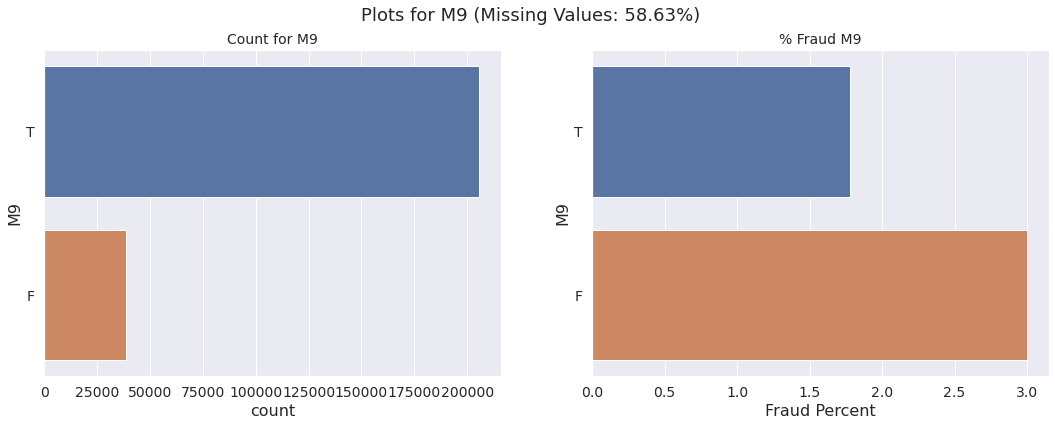

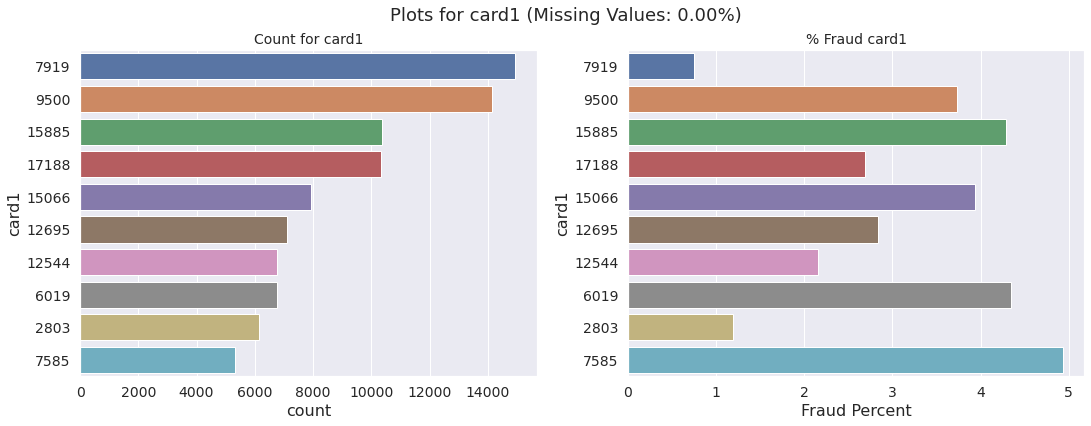

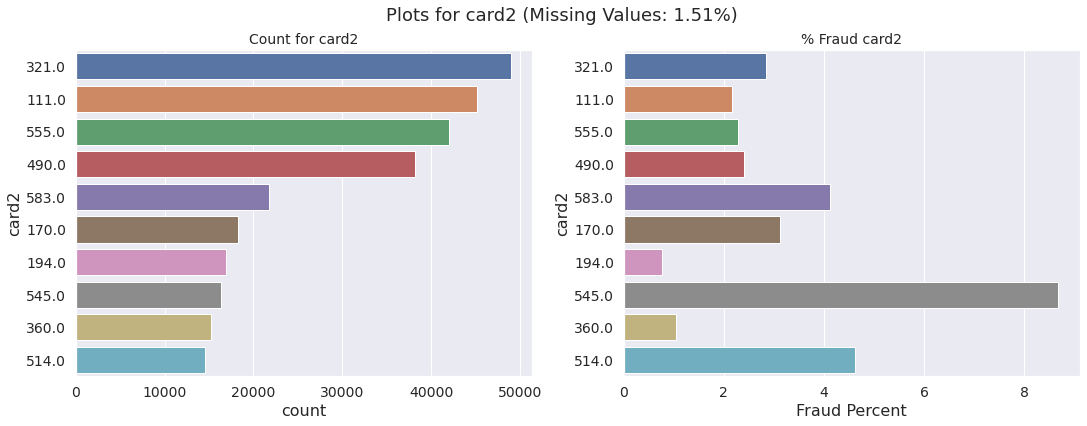

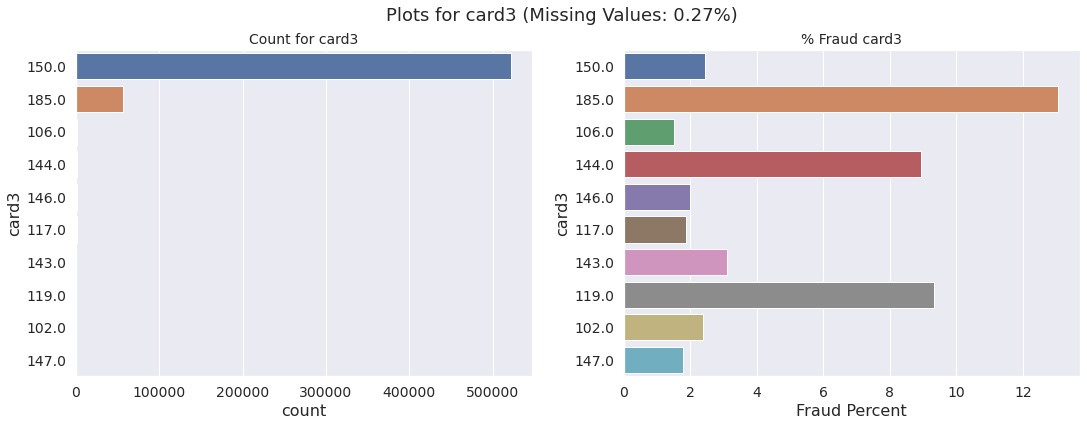

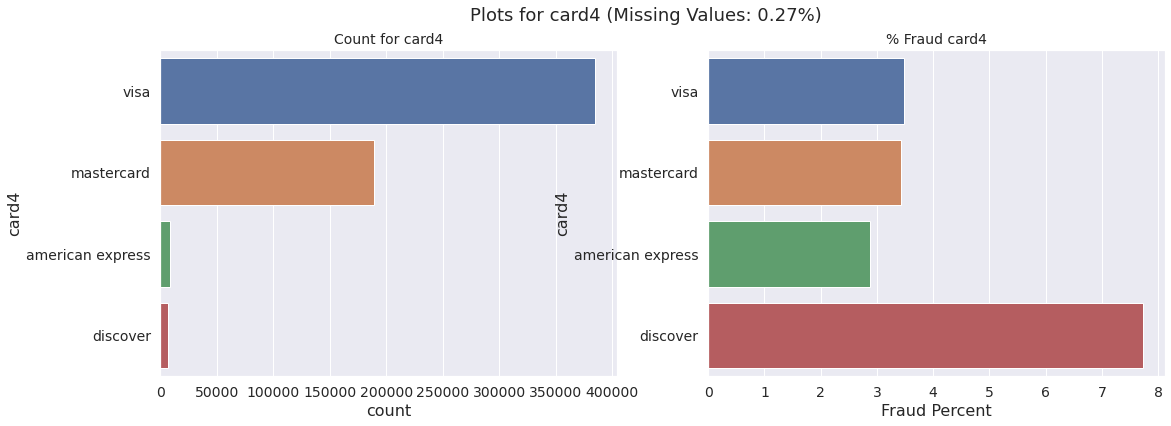

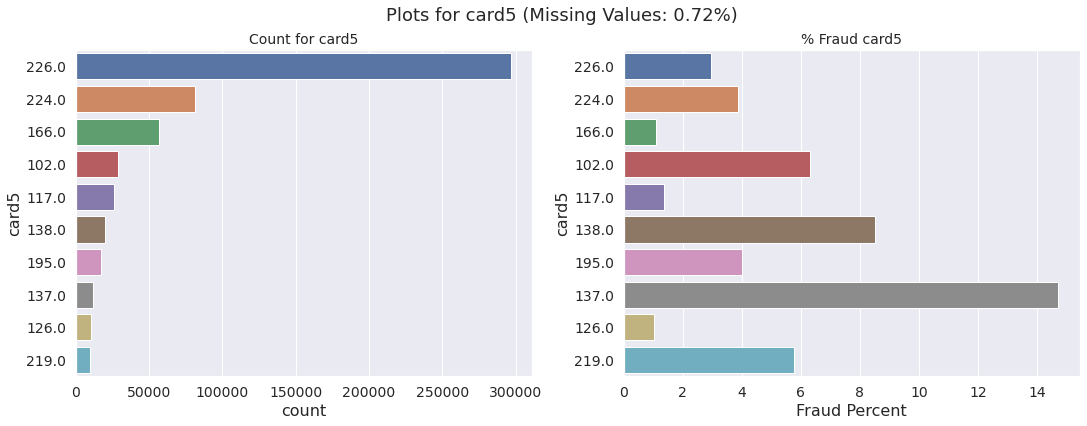

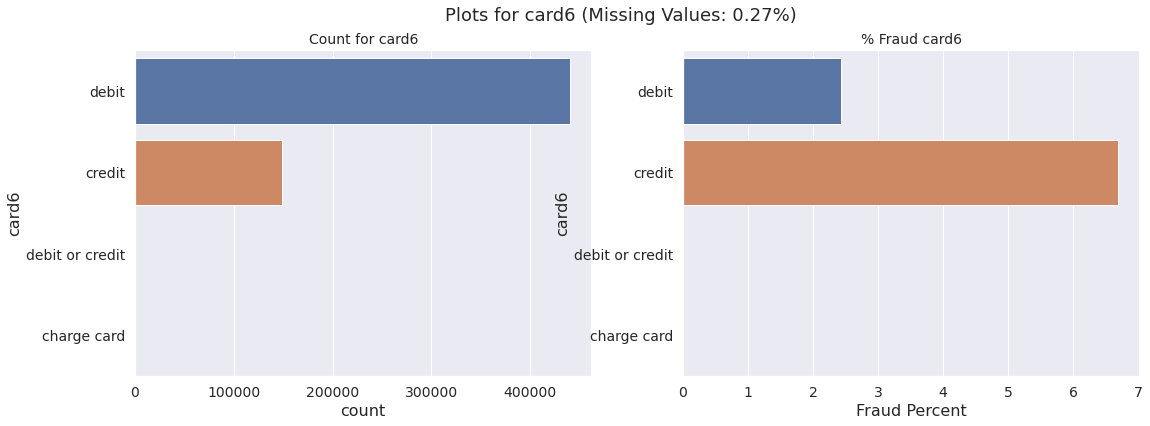

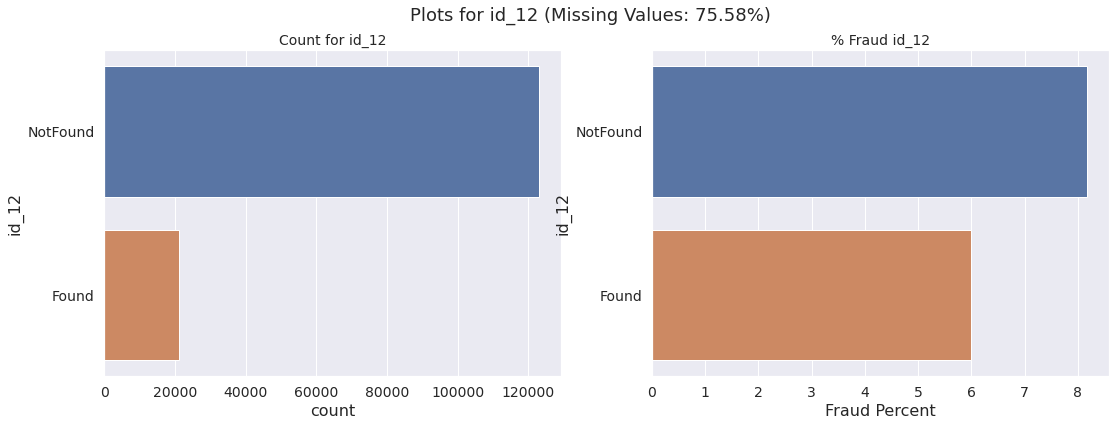

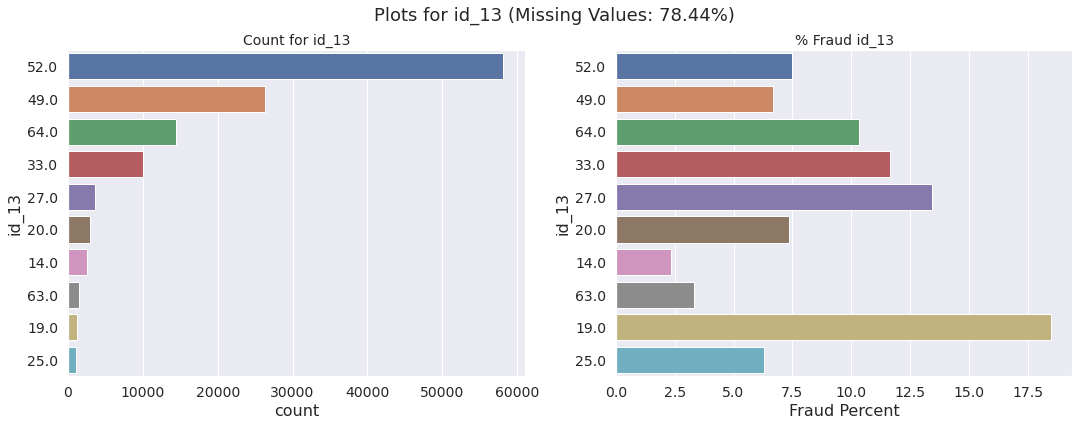

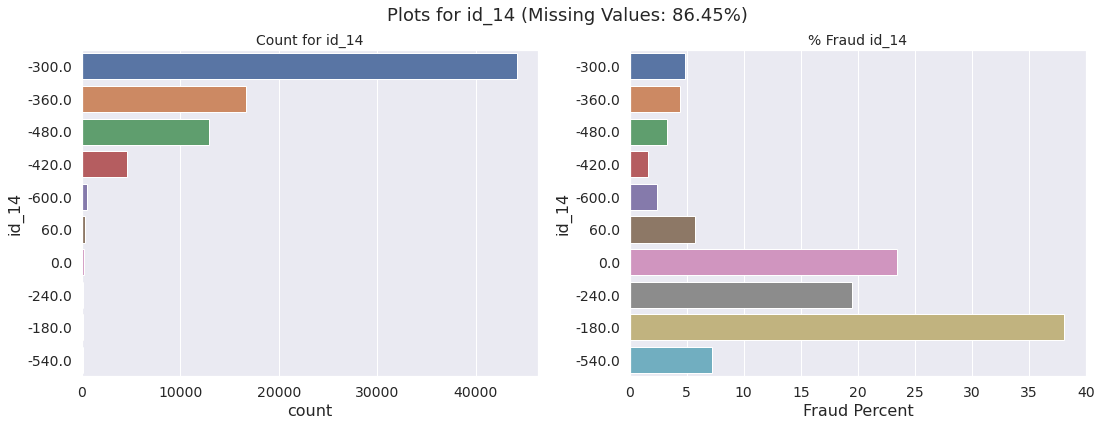

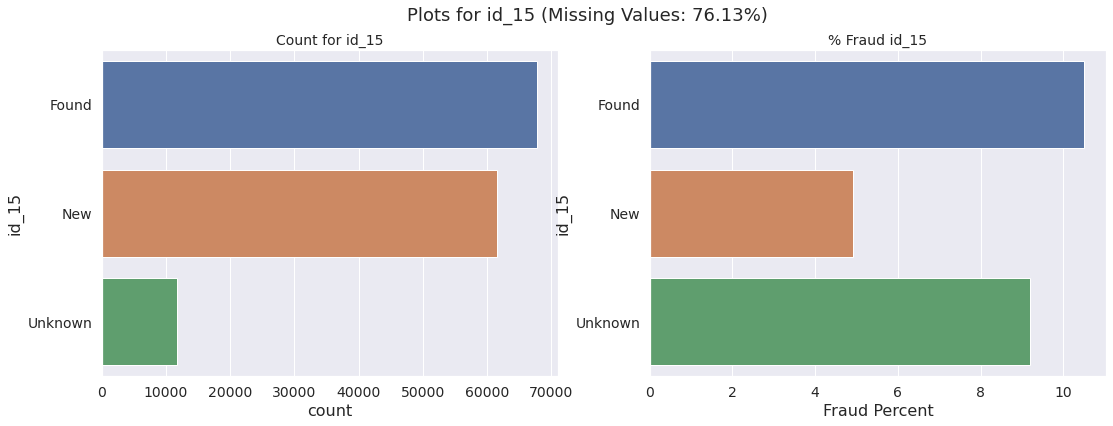

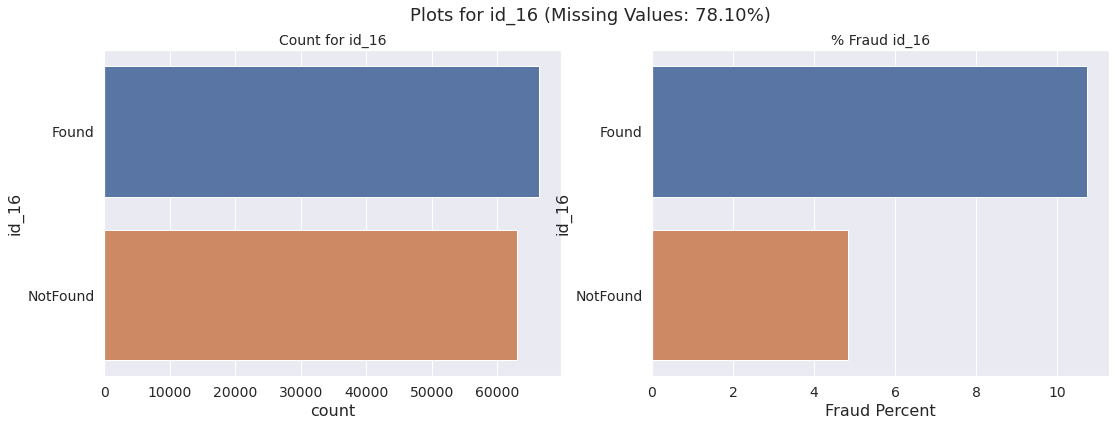

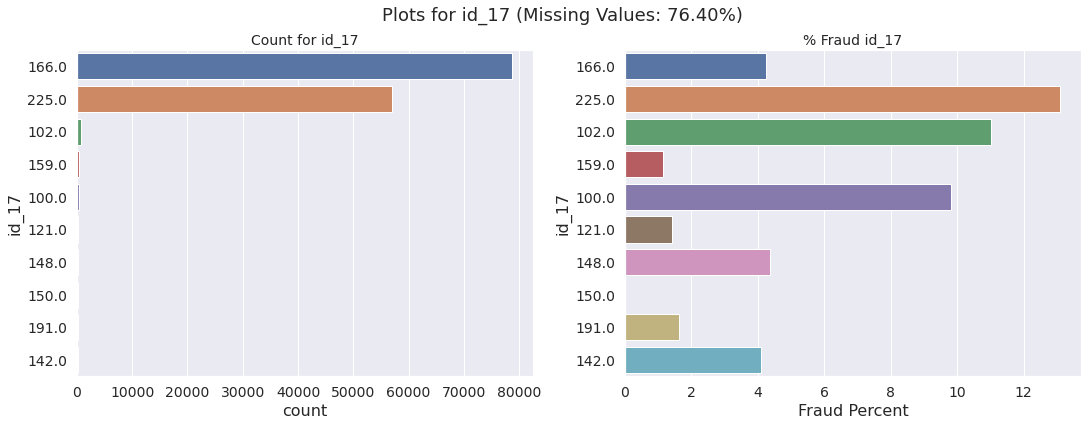

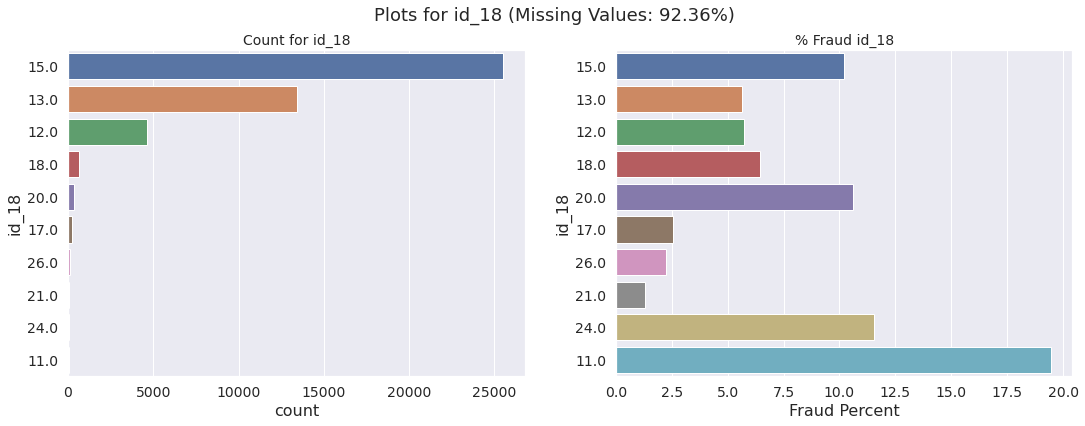

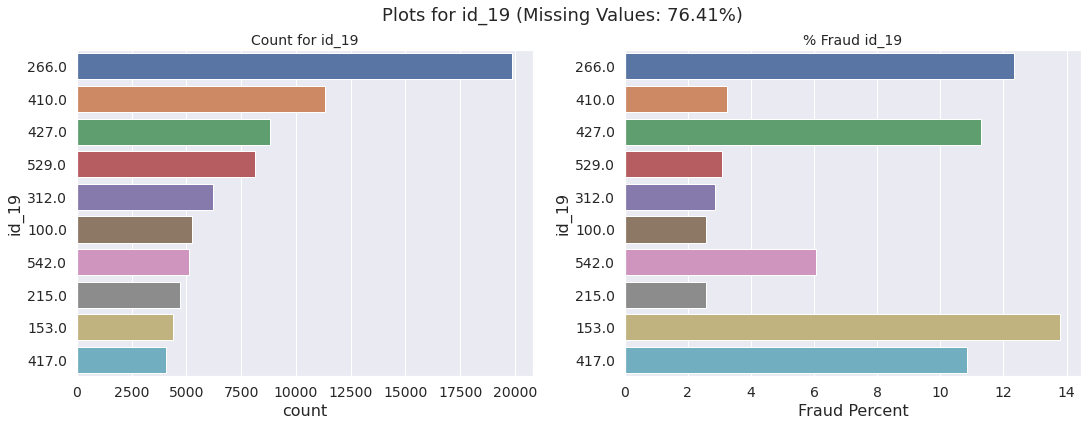

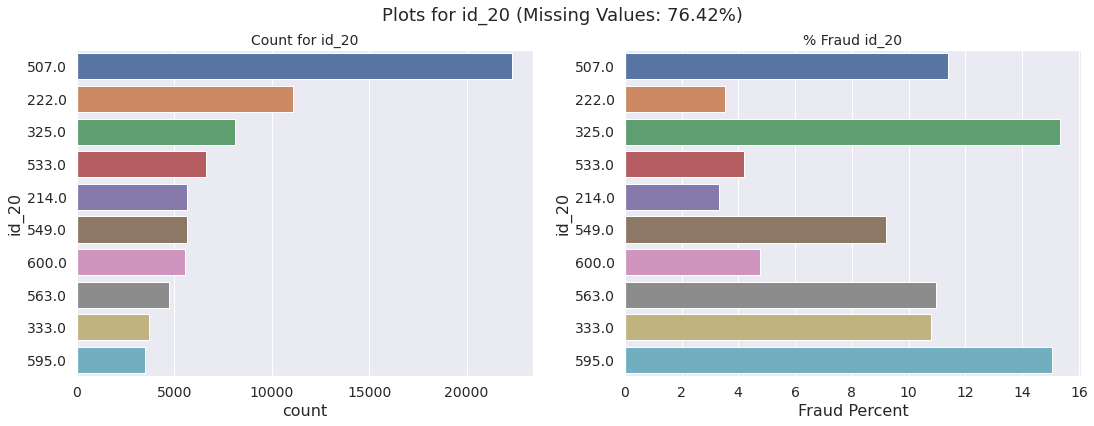

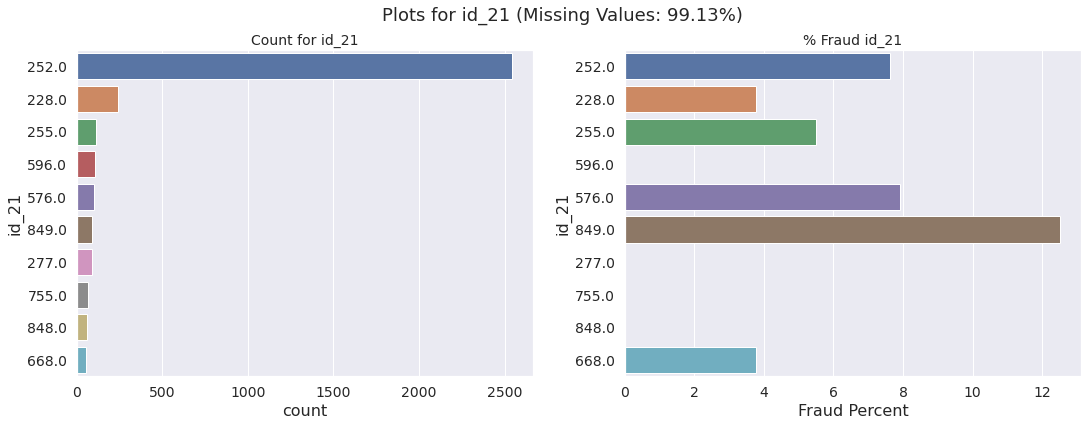

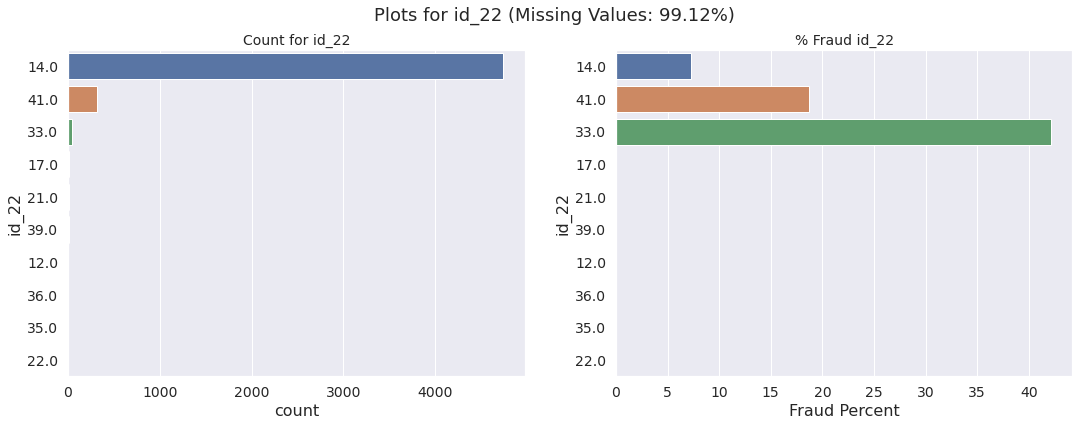

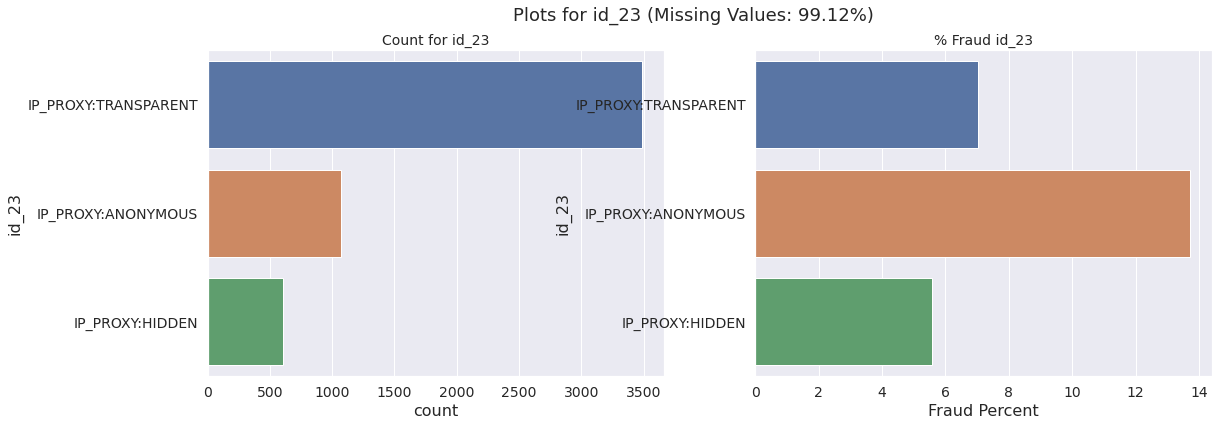

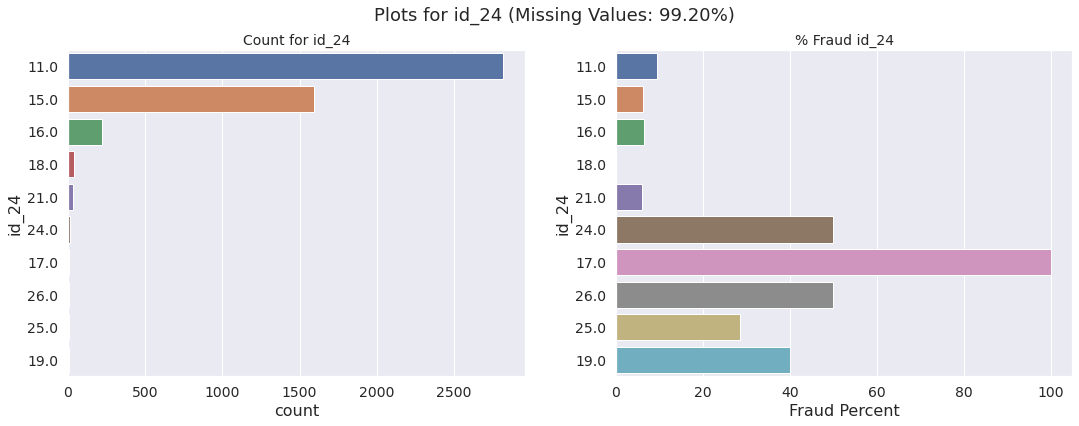

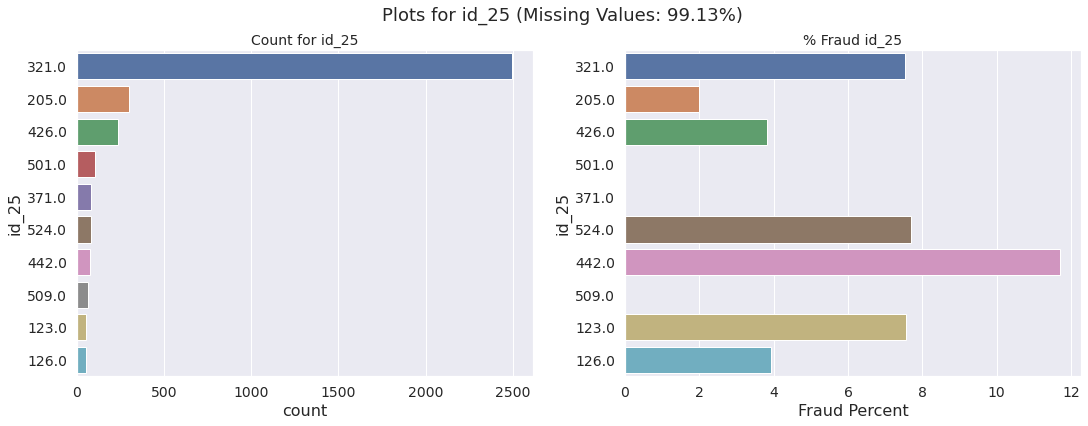

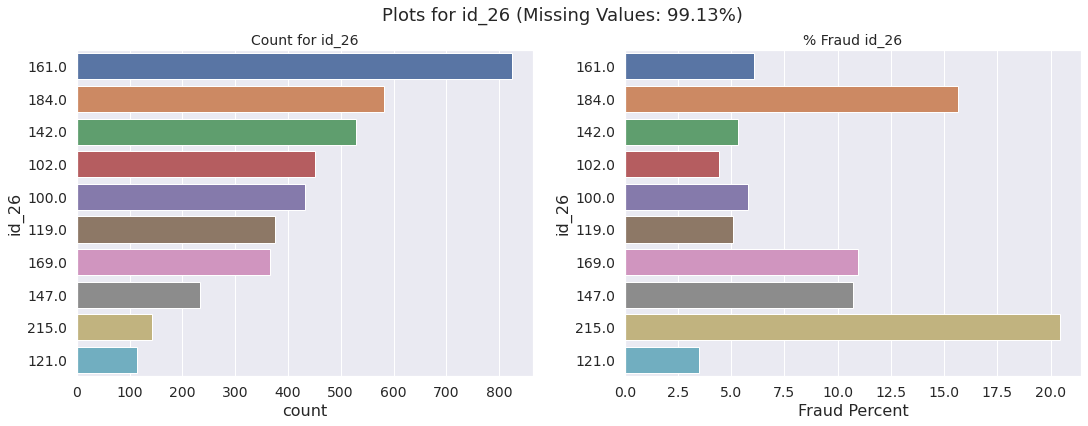

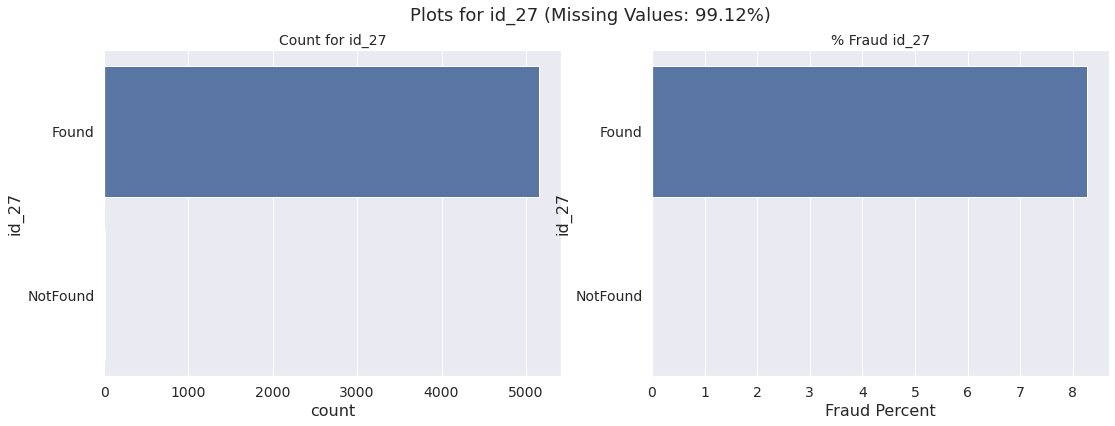

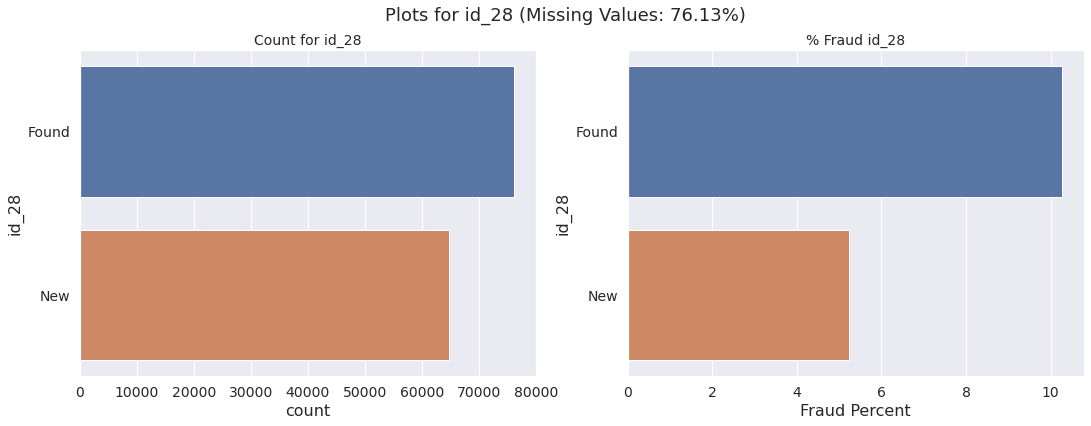

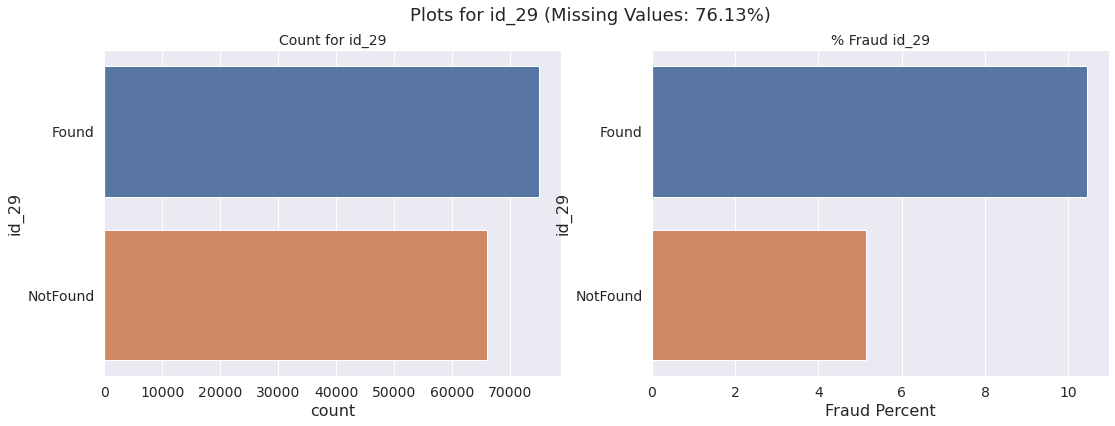

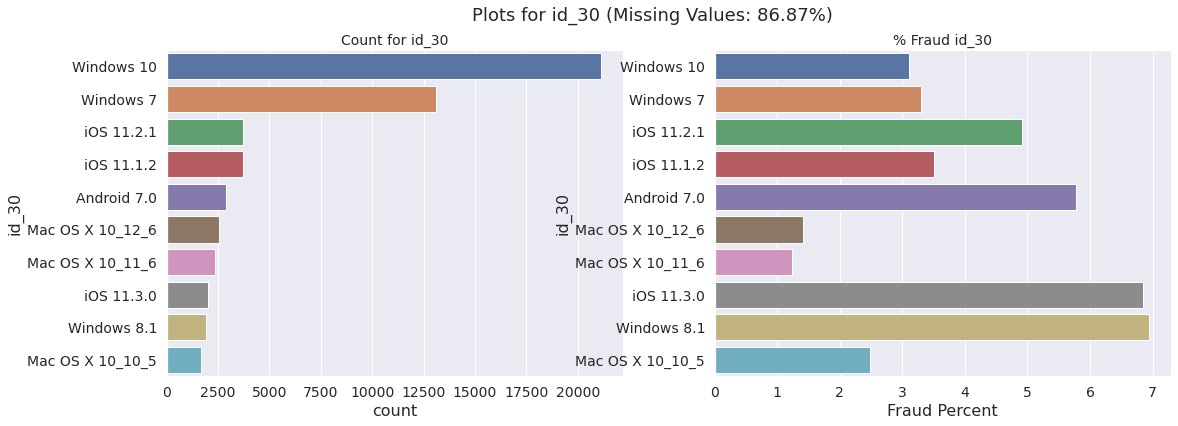

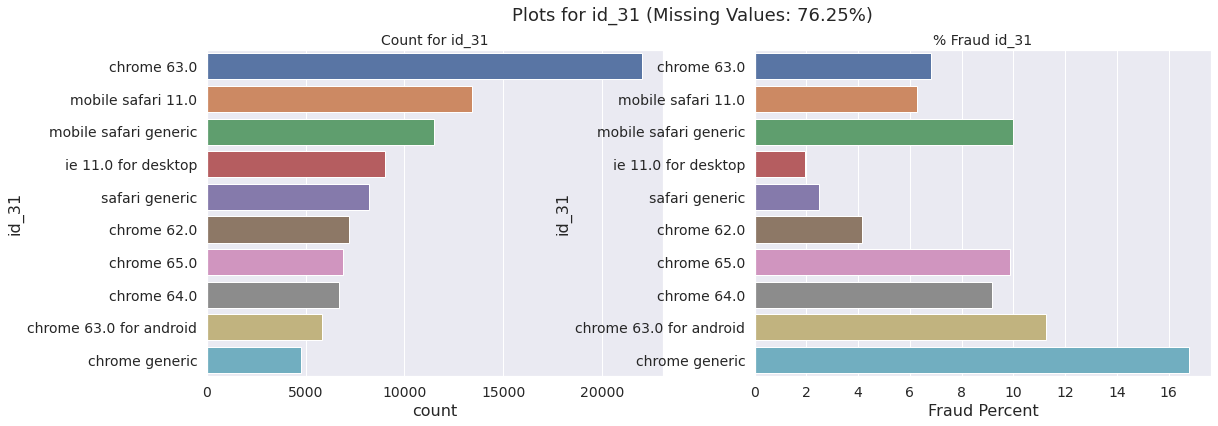

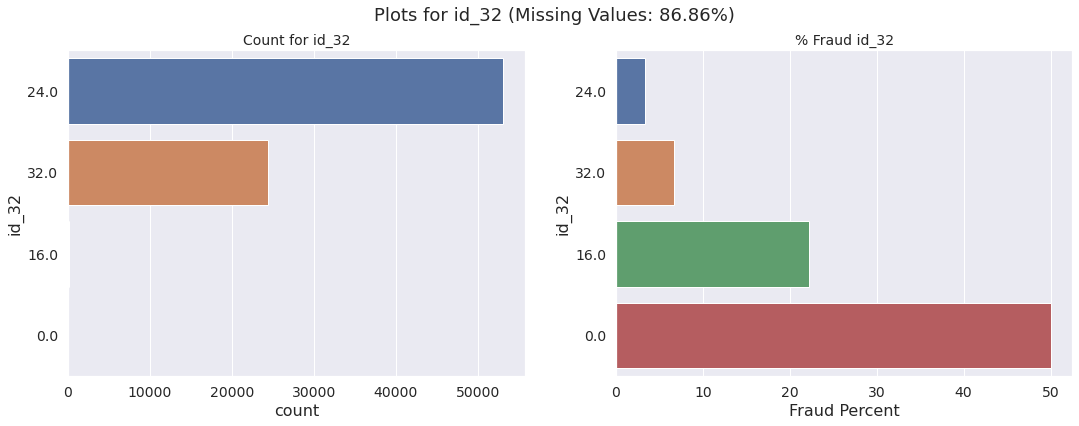

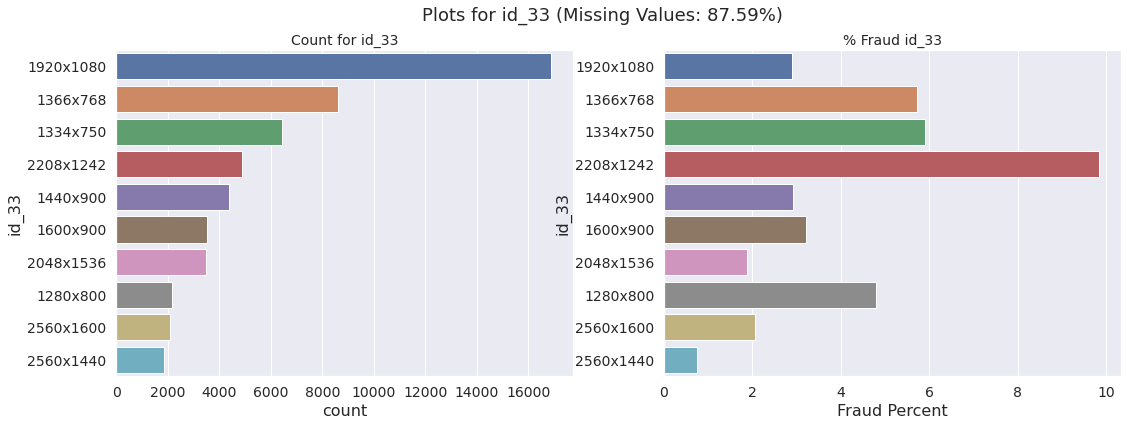

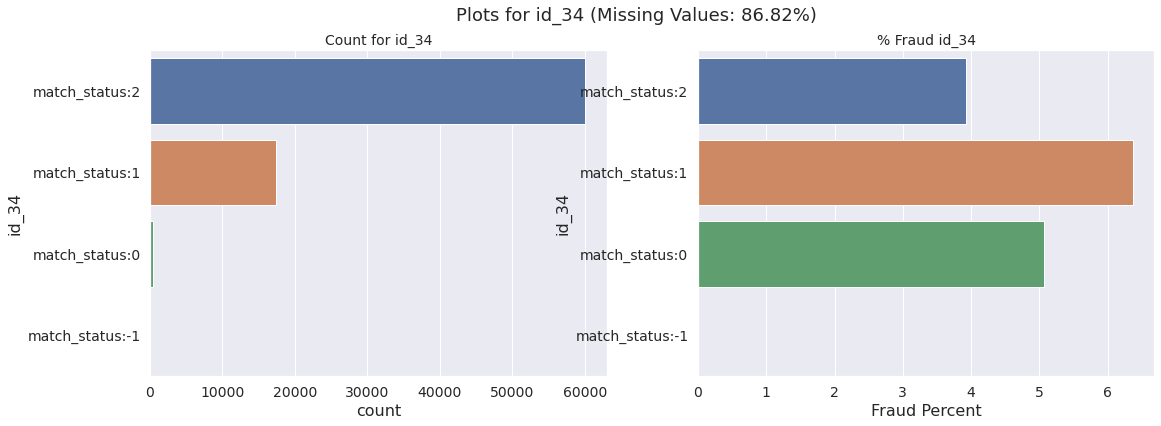

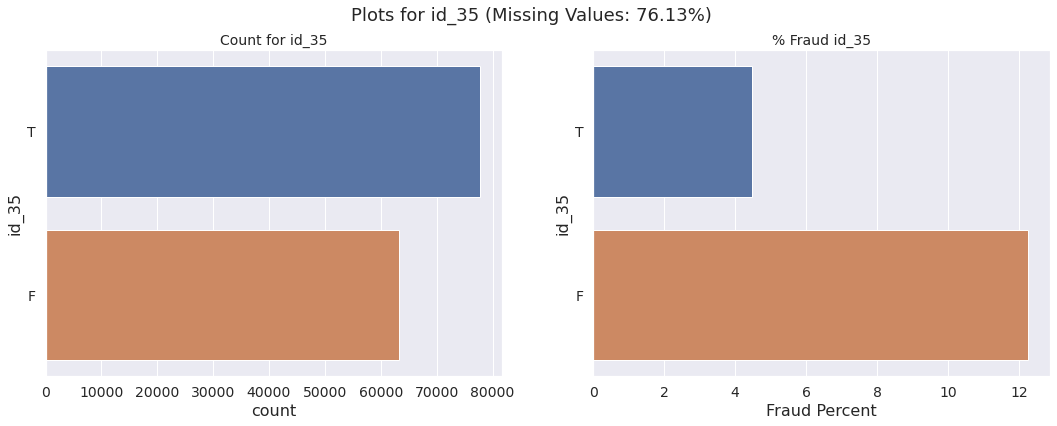

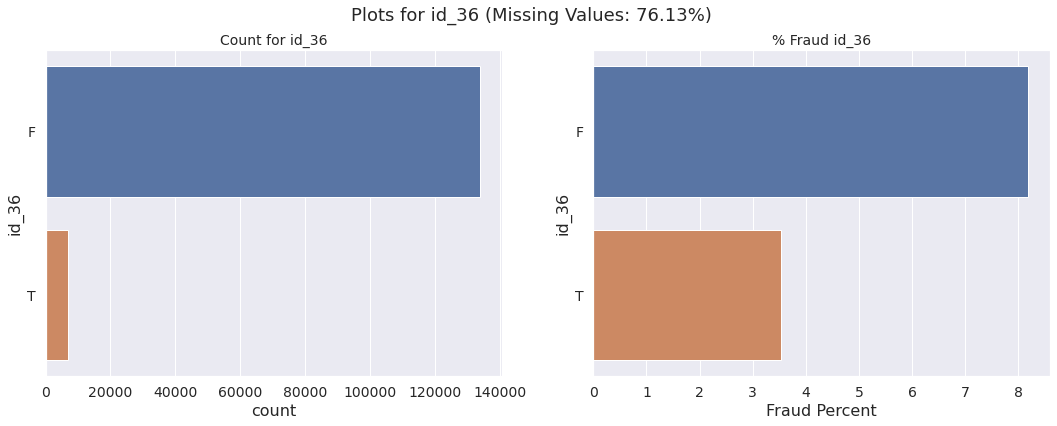

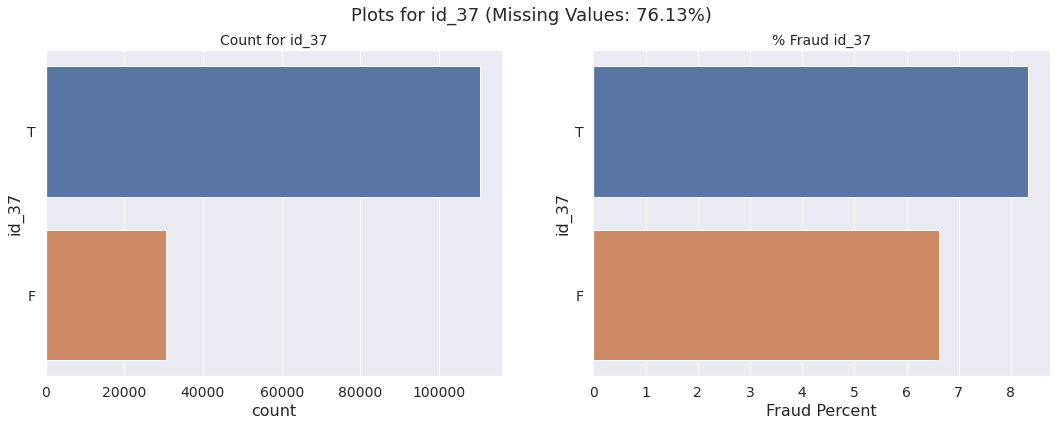

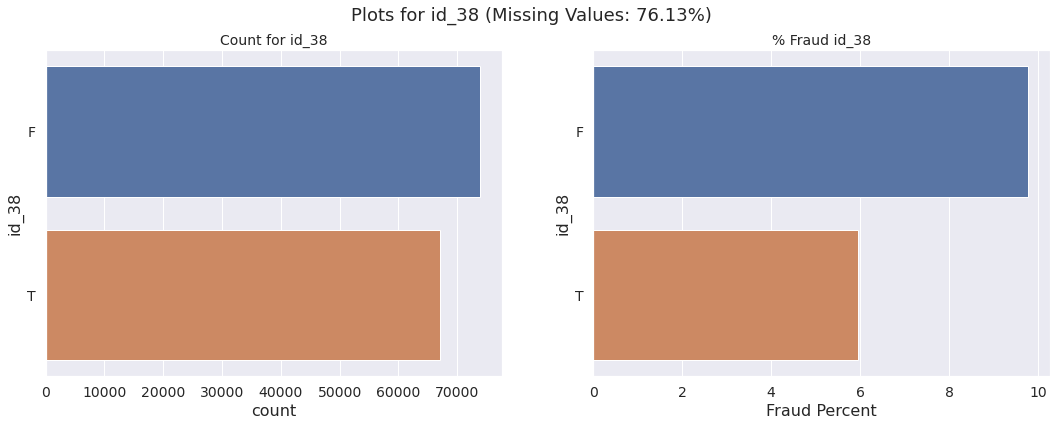

In [24]:
if SHOW_GRAPHS:
    for col in cat_cols:    
        plot_categorical_data(col, train, top_n = 10, display_data = False )

## EDA Numeric Features

* Since there are many columns we will restrict to features having less than 30% null values
* We will also filter those feature aving less than 100 unique values


In [25]:
def plot_numeric_data(df, col, target_col, remove_outliers = False):
   
    df = df[[col, target_col]].copy()
    df.dropna(subset=[col], inplace =True)
    
    #Remove Outliers: keep only the ones that are within +3 to -3 standard deviations in the column 
    if remove_outliers:       
       
        df = df[np.abs(df[col]-df[col].mean()) <= (3*df[col].std())]
       


    fig, (ax1, ax2,ax3)  =  plt.subplots(ncols = 3, figsize = (24,4))
    fig.suptitle('Plots for {}'.format(col))
    
    #Display Density Plot
    sns.distplot(df[col], color = 'b',  kde = True ,  ax = ax1 )
    plt.ylabel('Density')


    # Display Box Plot for feature
    sns.boxplot(x = col , data = df,ax = ax2)
   
    #Display Density Plot for Fraud Vs NotFraud
    sns.distplot(df[df[target_col] == 0][col], color = 'b', label = 'NotFraud',ax = ax3)
    sns.distplot(df[df[target_col] == 1][col], color = 'r', label = 'Fraud',ax = ax3)
    plt.legend(loc = 'best')
    plt.ylabel('Density NotFraud vs Fraud')

    plt.show()

In [26]:
%%time
#Get subset of numerical columns only
num_cols_filtered   = col_prop_trn[col_prop_trn.index.isin(num_cols)]

#only select those coluumns which a missing value % less than a threshold(30%)
num_cols_filtered = num_cols_filtered[num_cols_filtered.perc_null < 30]

# Select columns with >= 100 distinct values
num_cols_filtered = num_cols_filtered[num_cols_filtered.count_unique >= 100]

print('Number of features:{}'.format(len(num_cols_filtered.index.tolist())))



Number of features:61
CPU times: user 3.46 ms, sys: 65 µs, total: 3.53 ms
Wall time: 3.22 ms


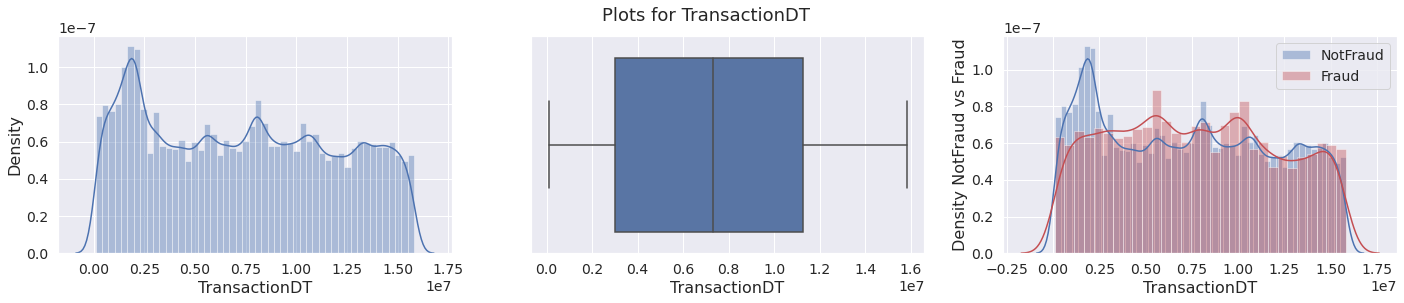

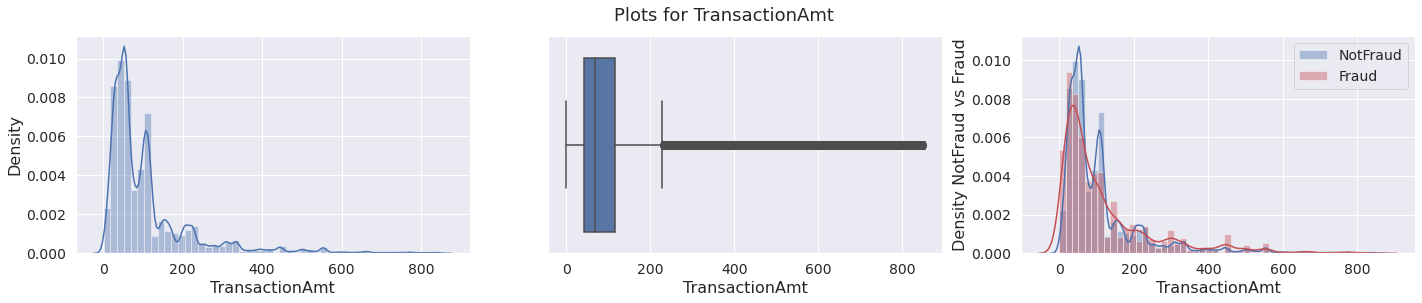

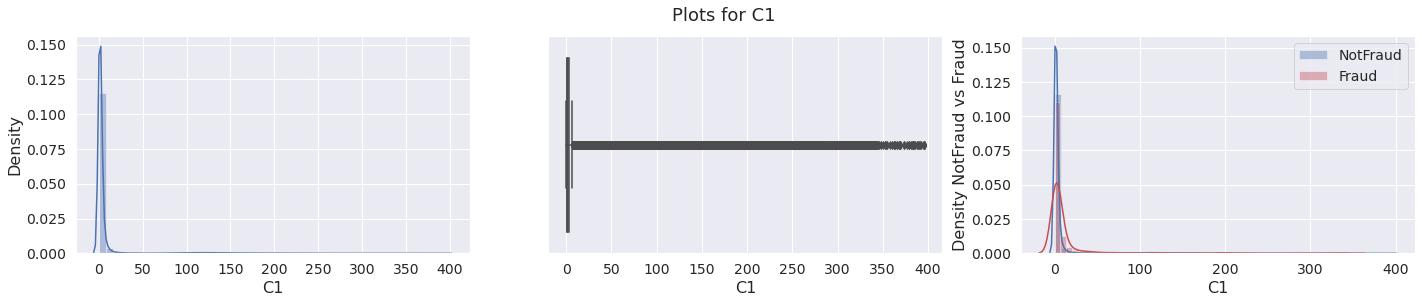

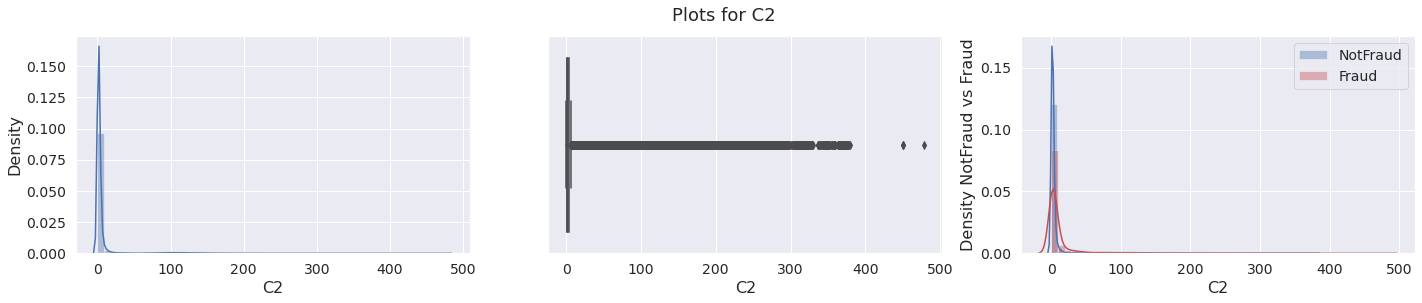

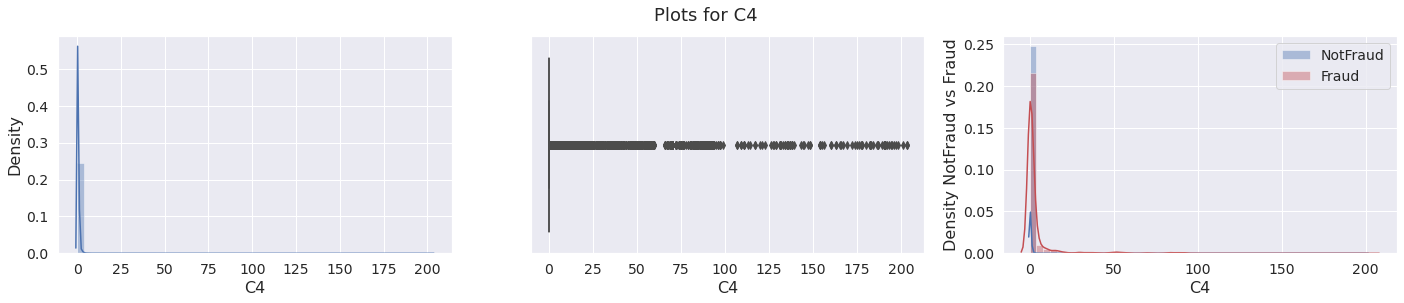

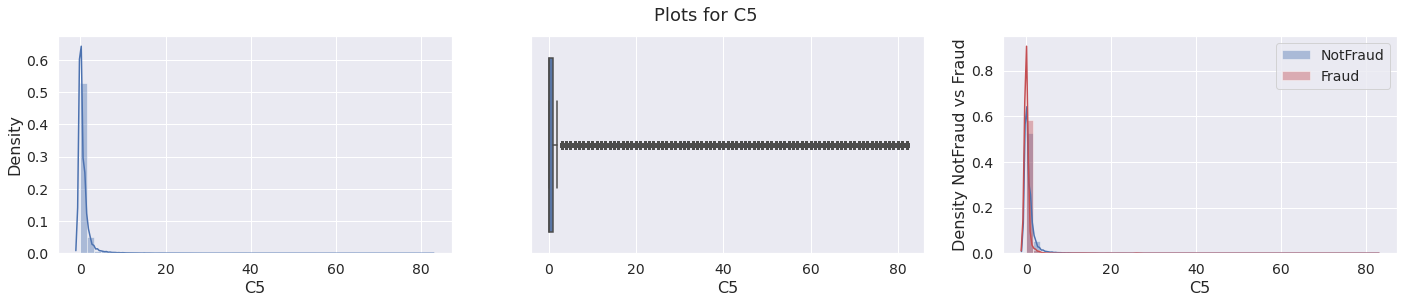

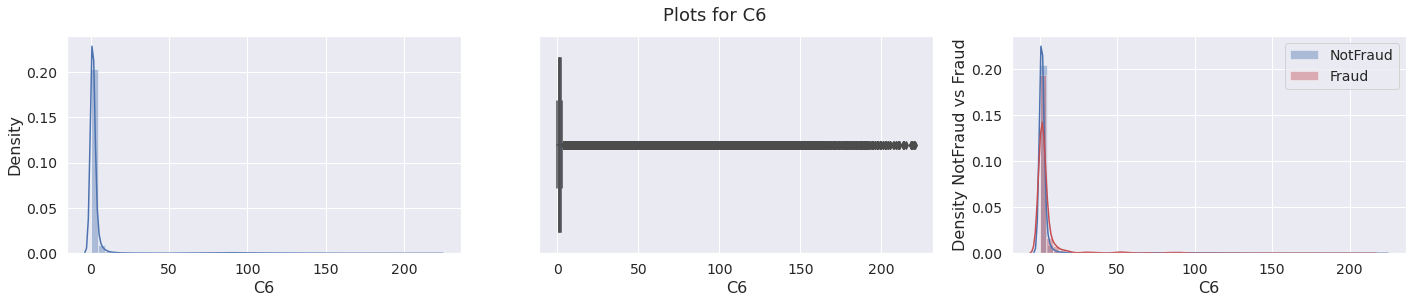

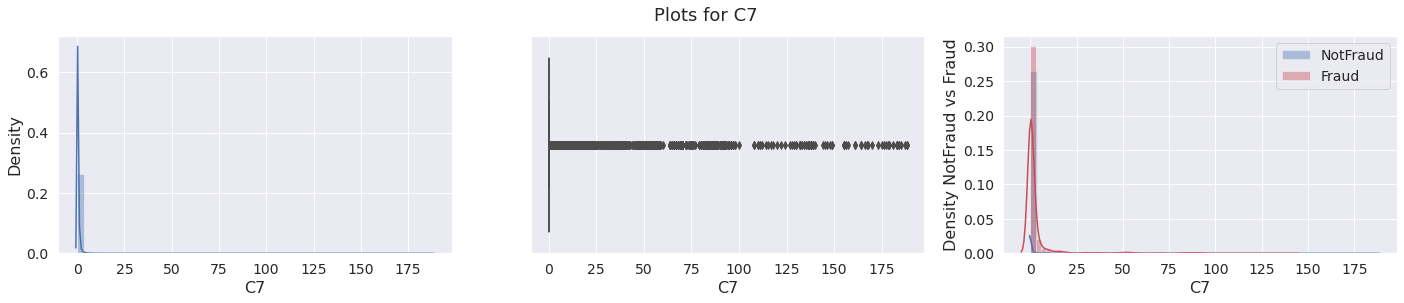

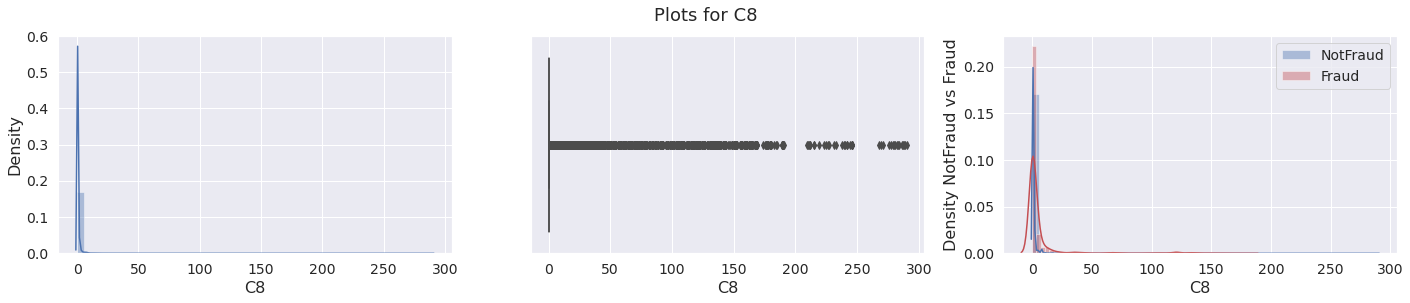

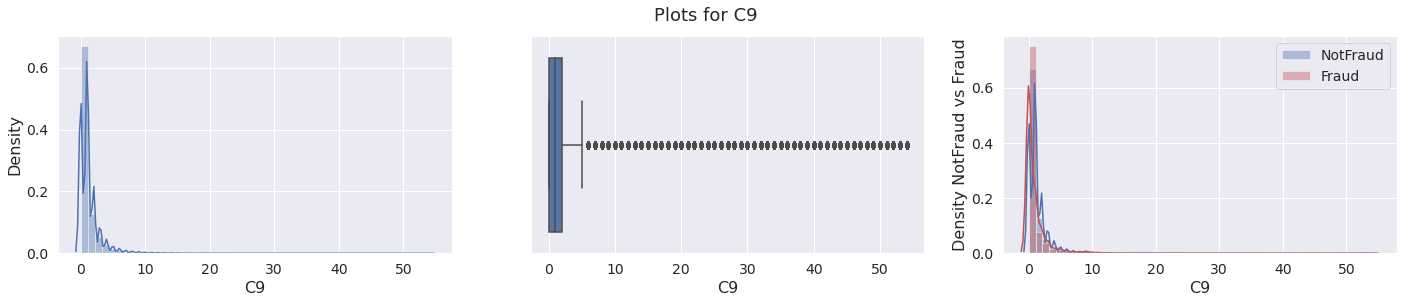

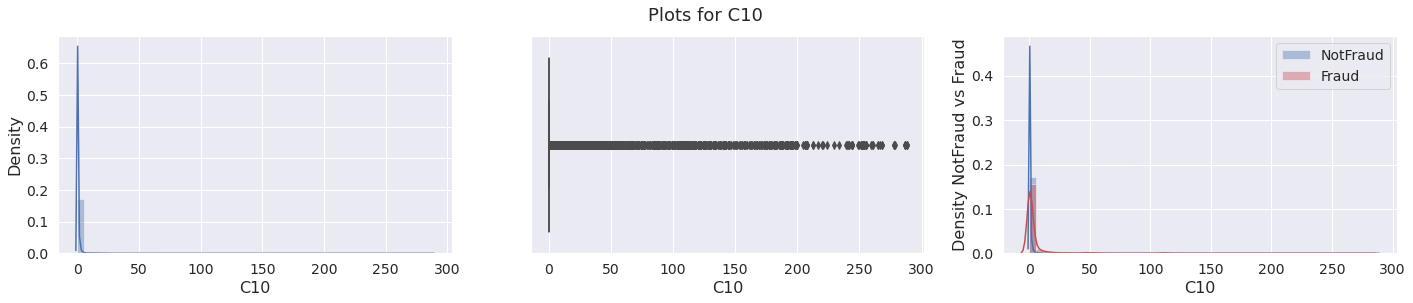

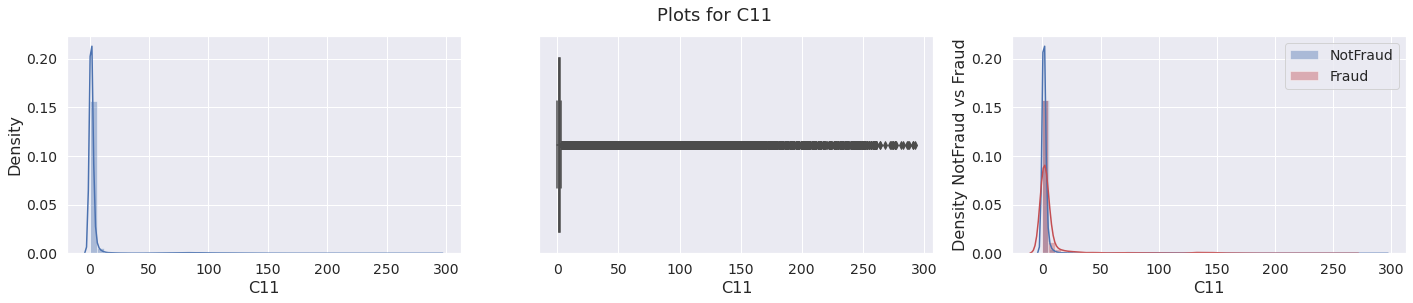

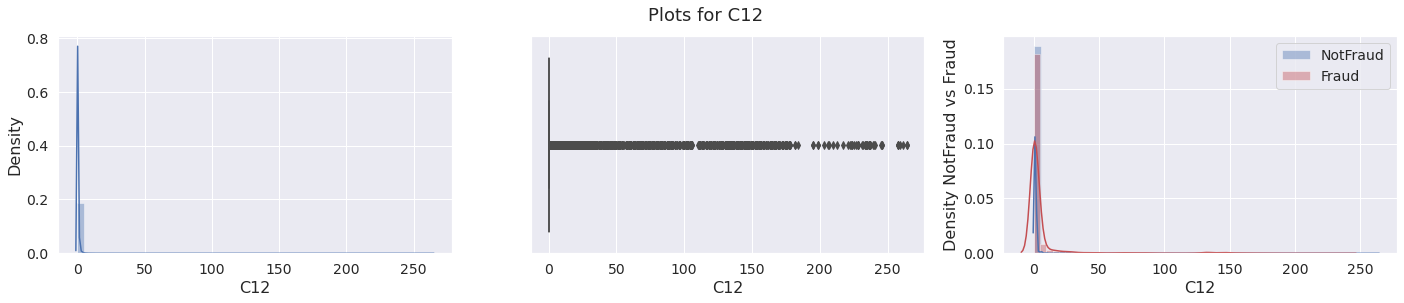

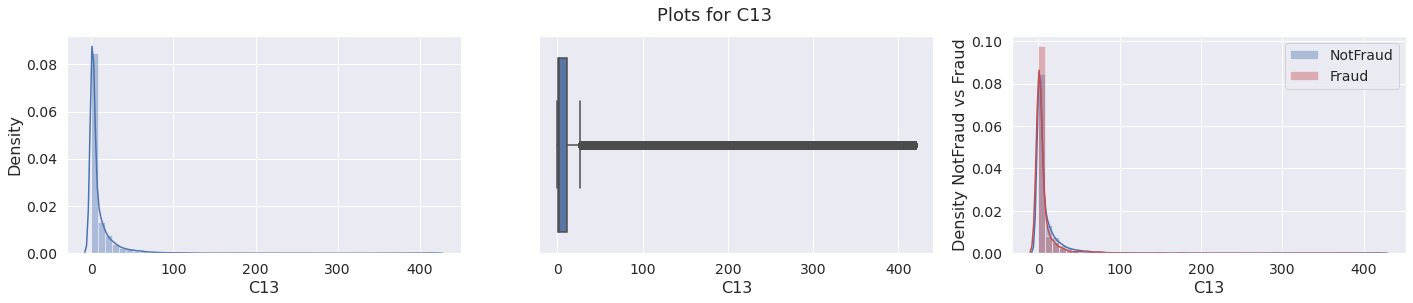

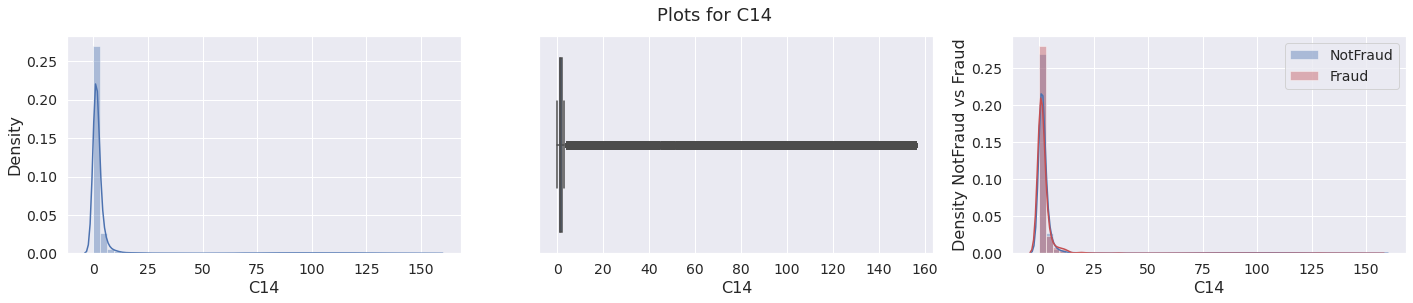

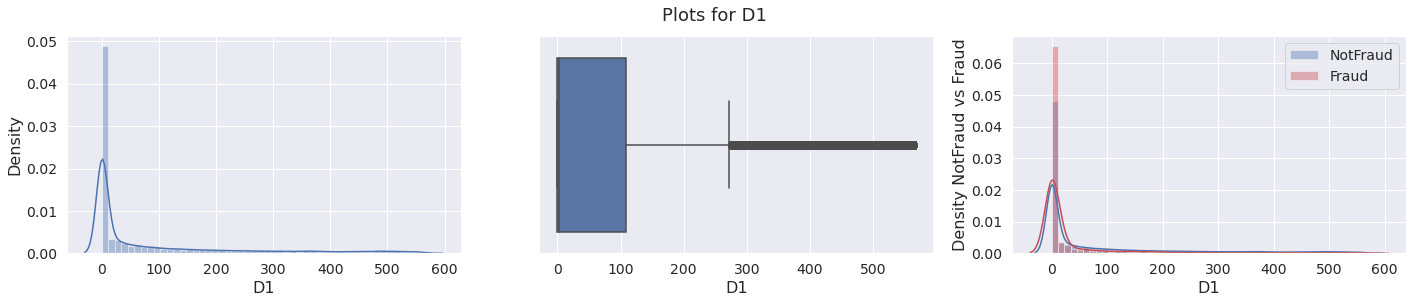

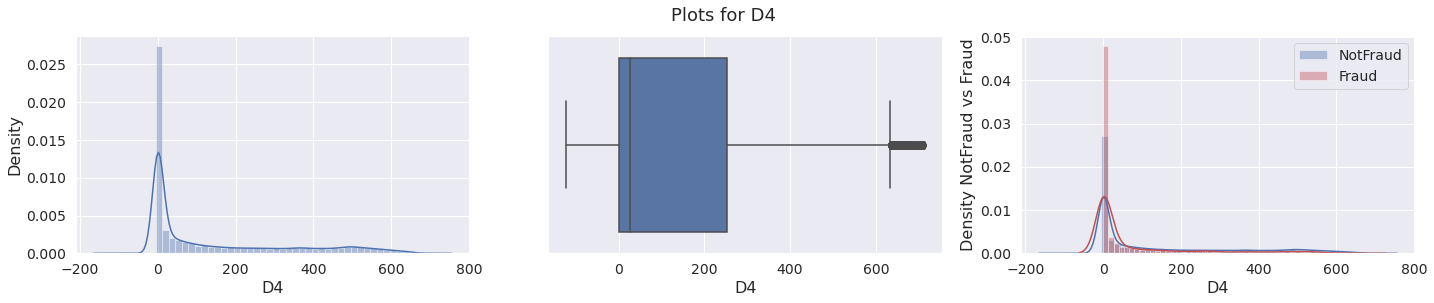

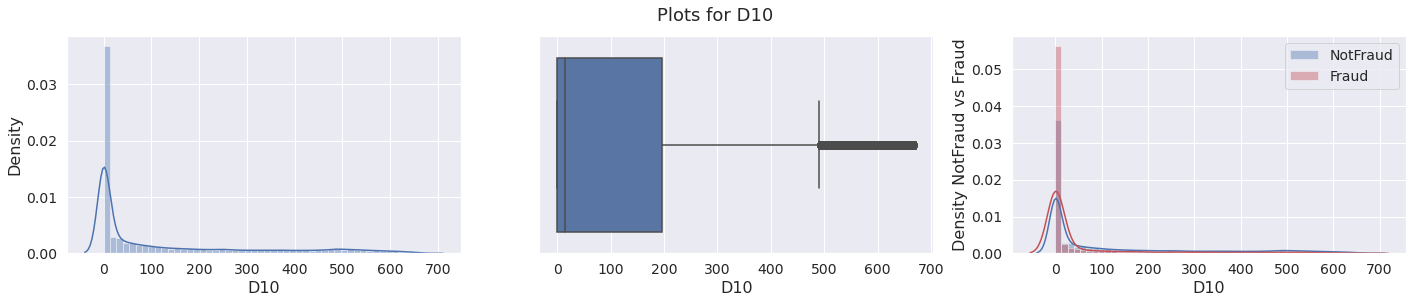

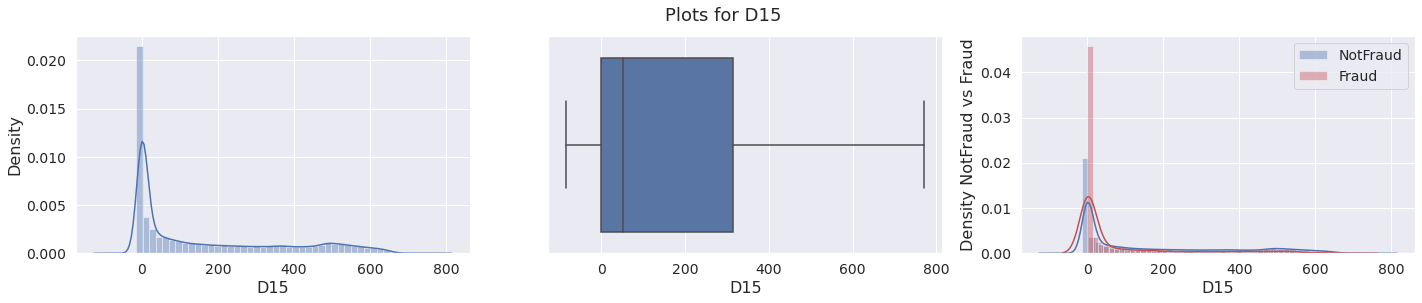

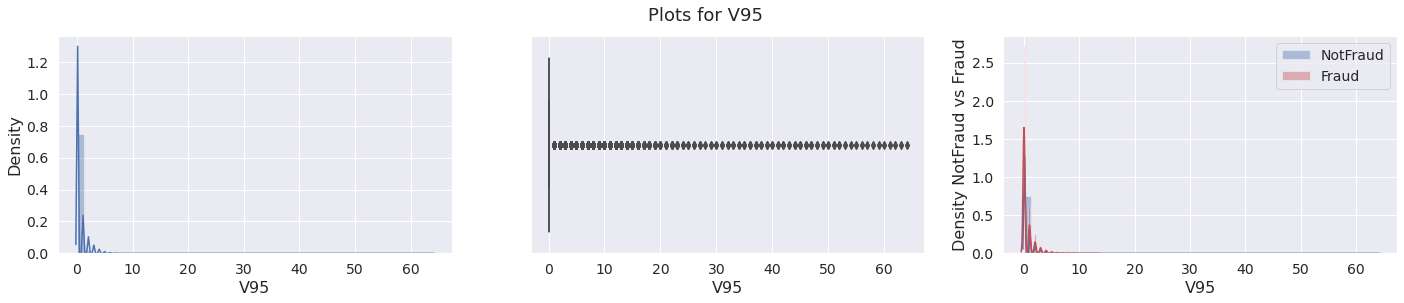

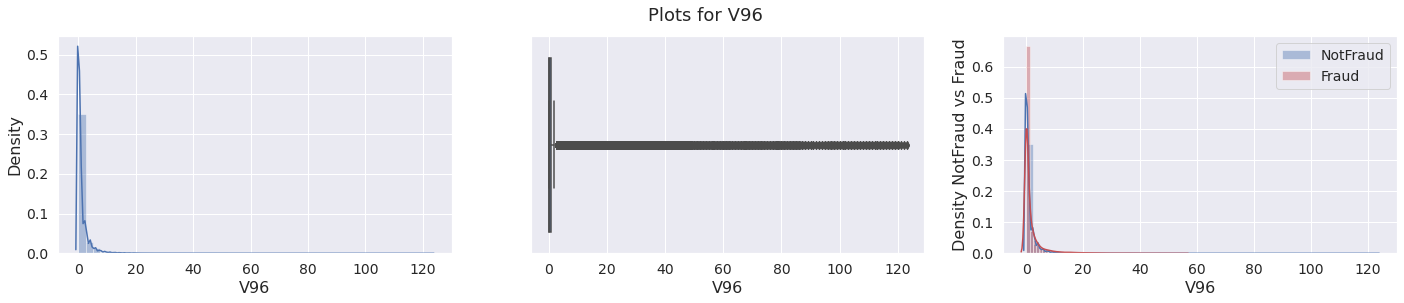

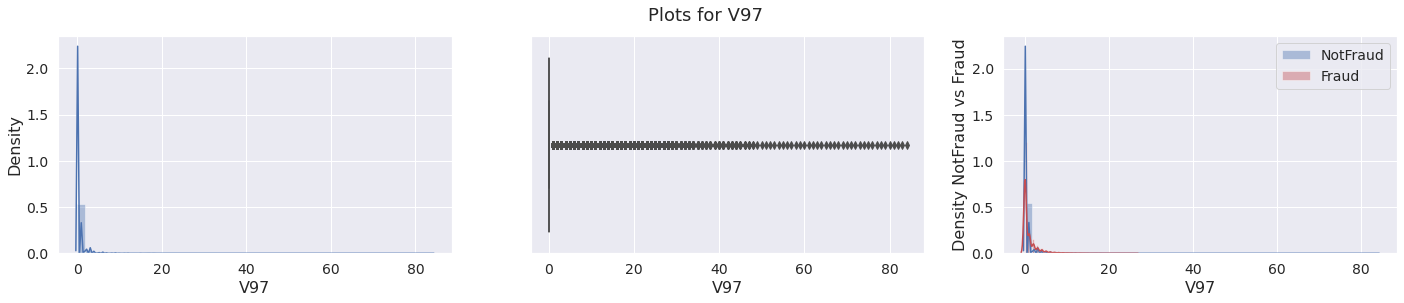

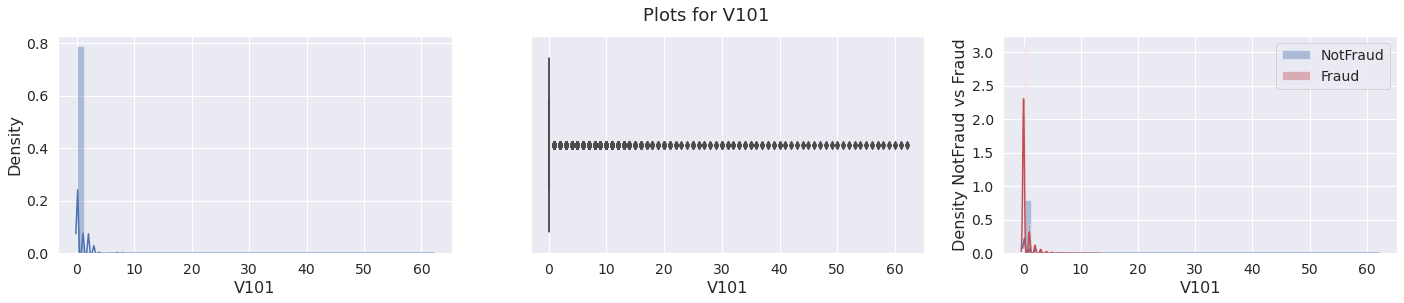

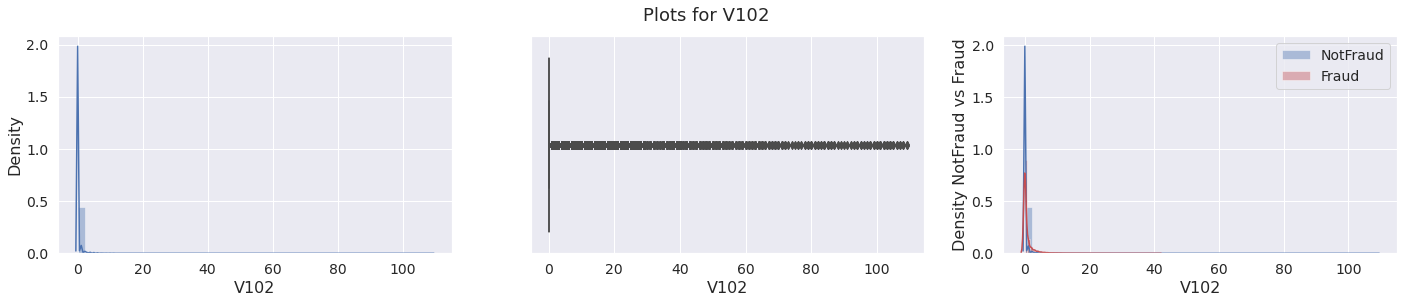

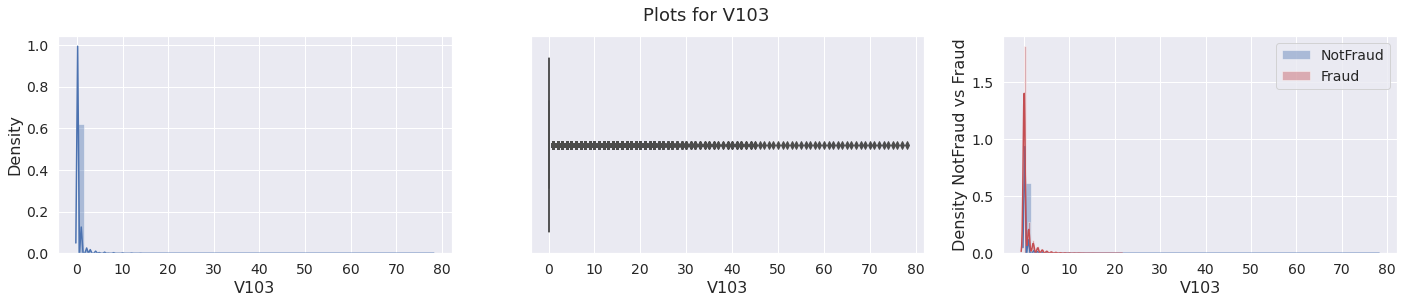

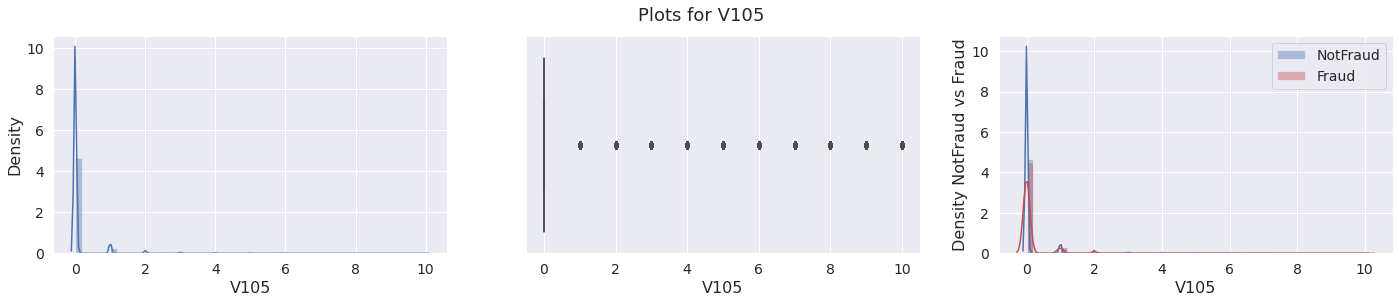

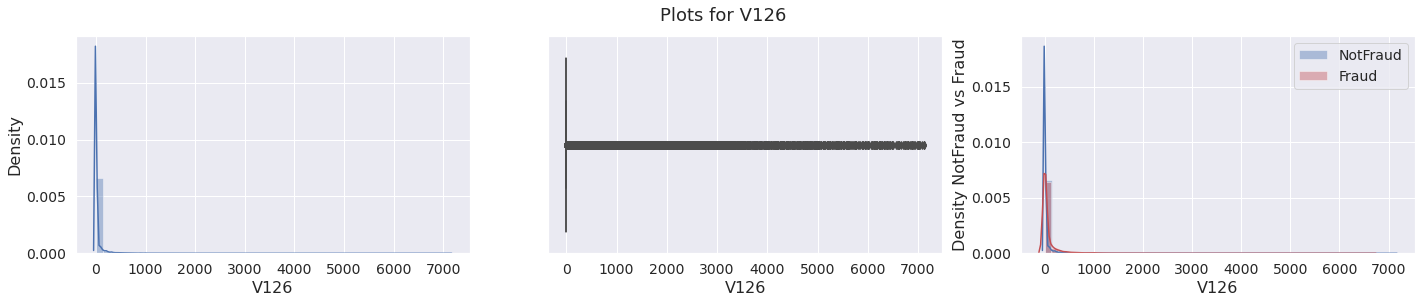

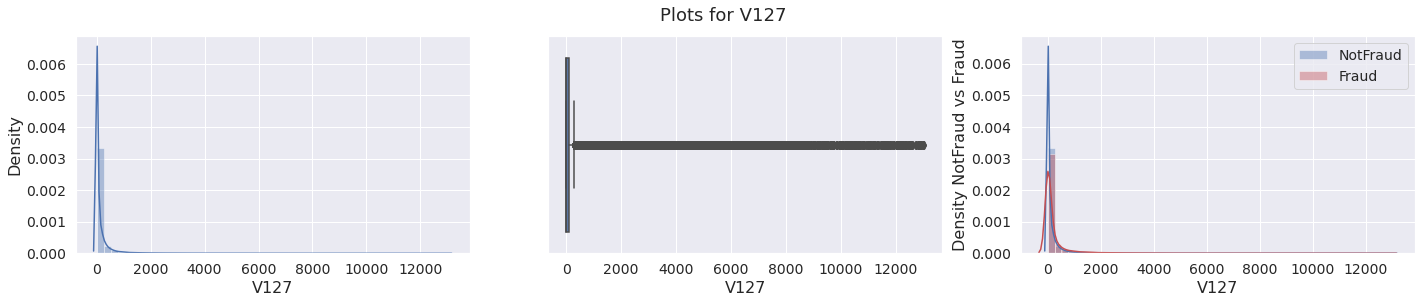

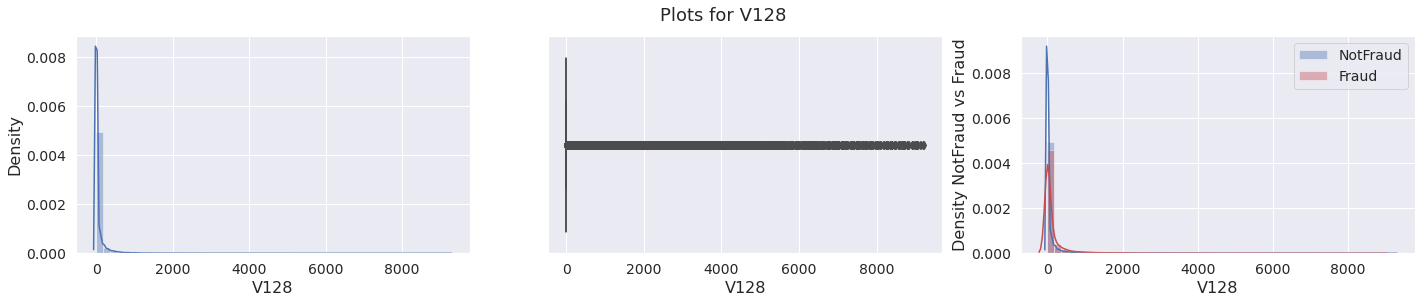

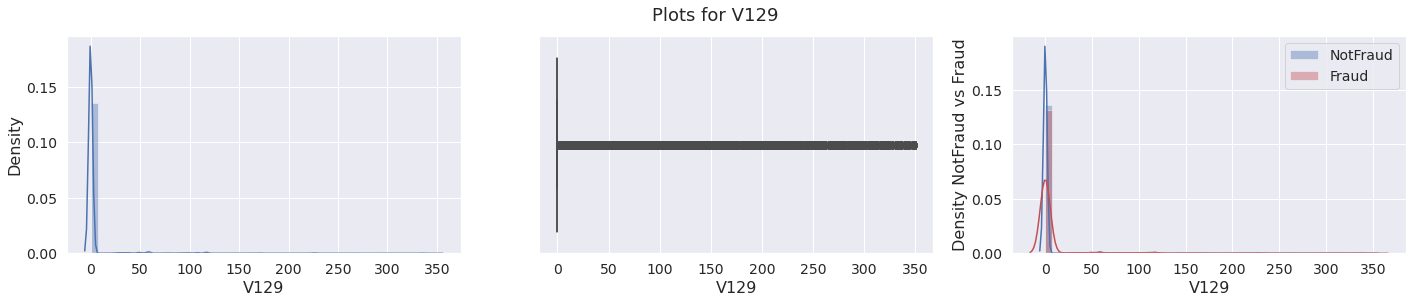

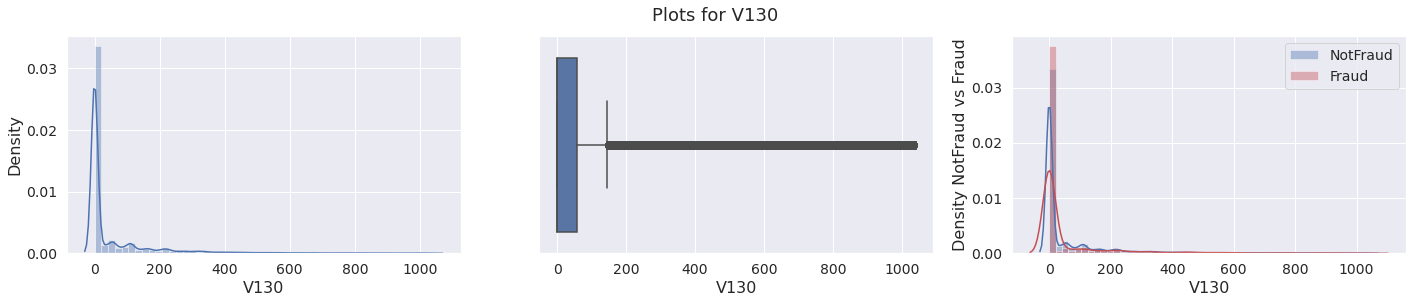

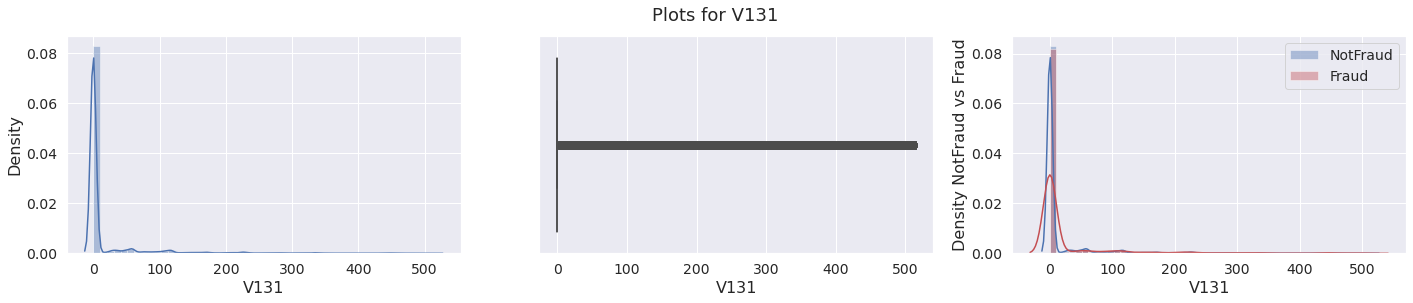

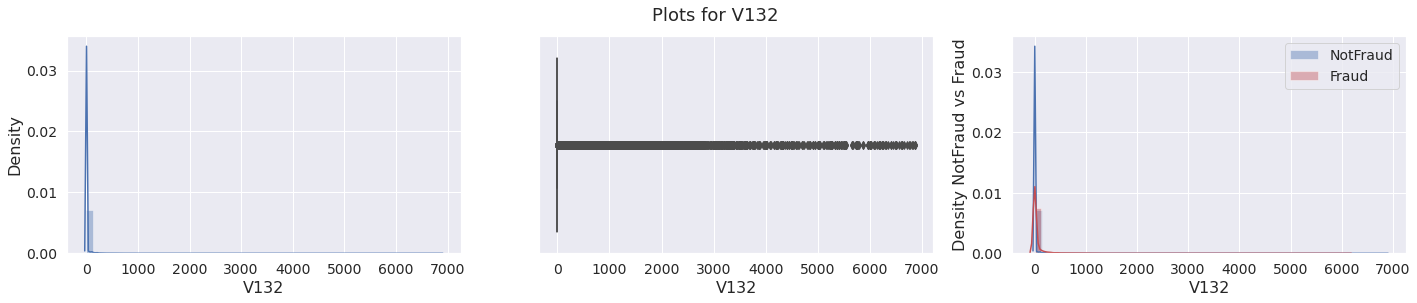

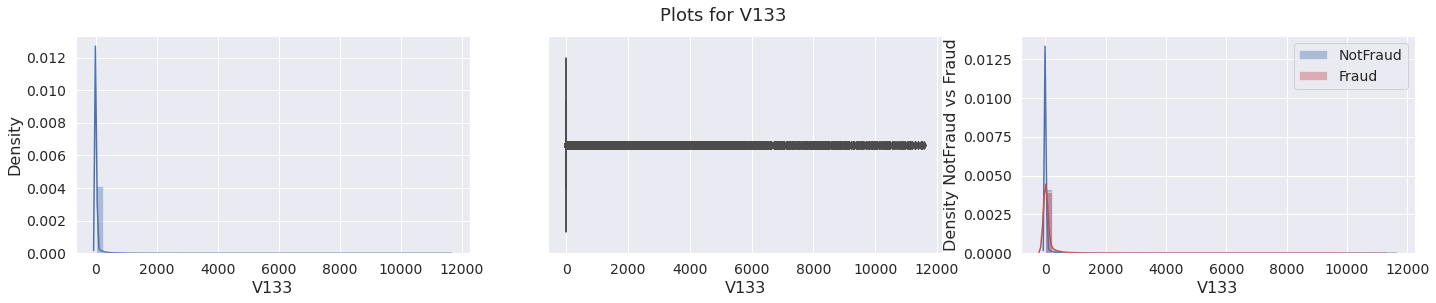

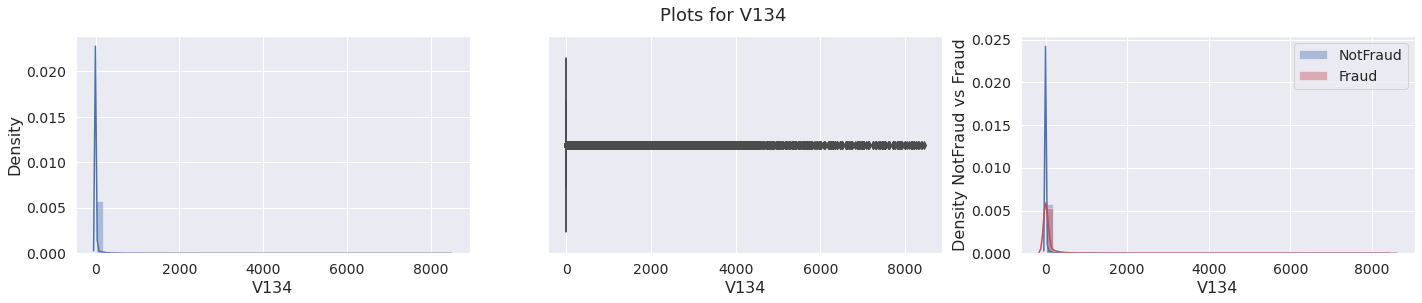

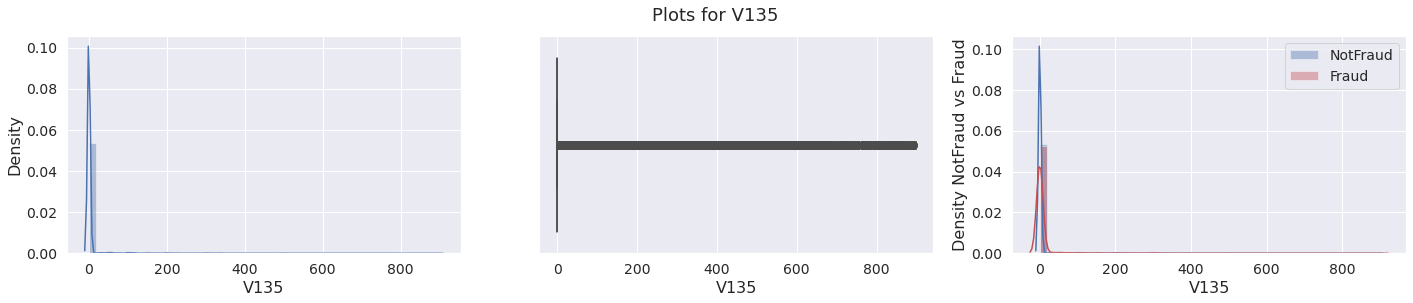

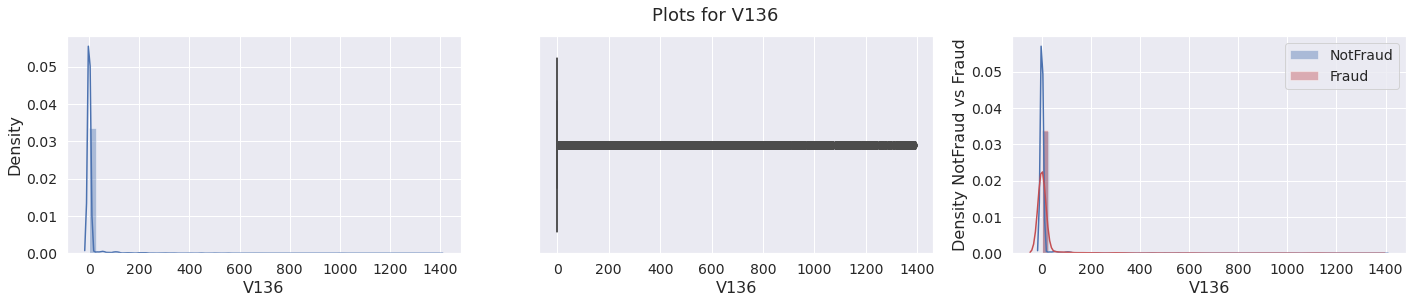

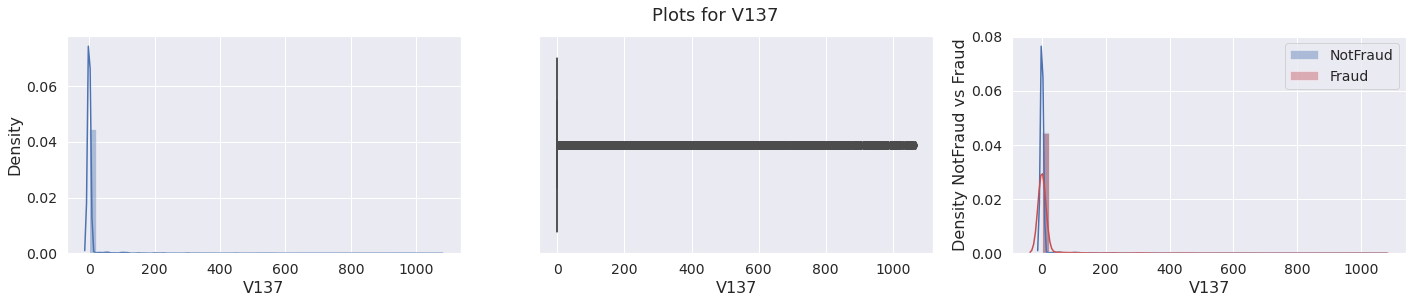

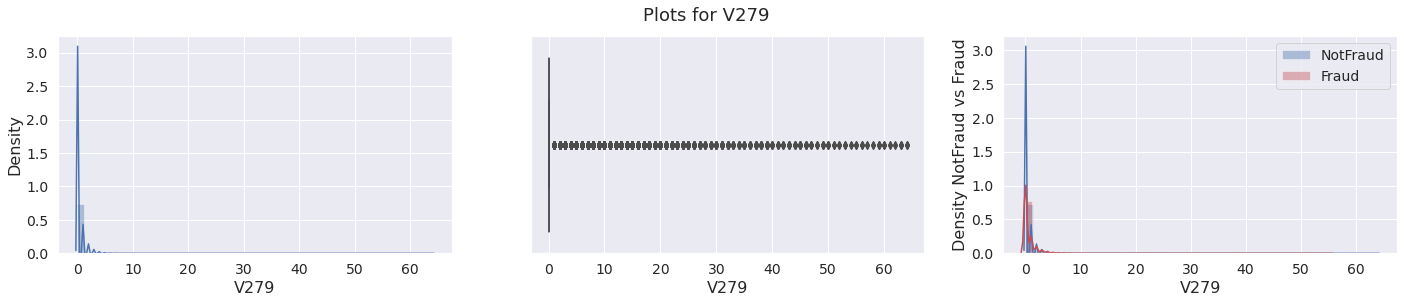

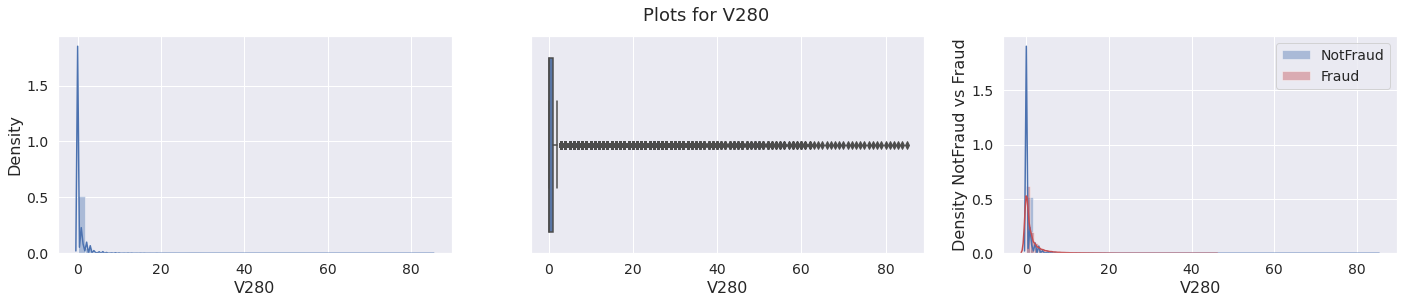

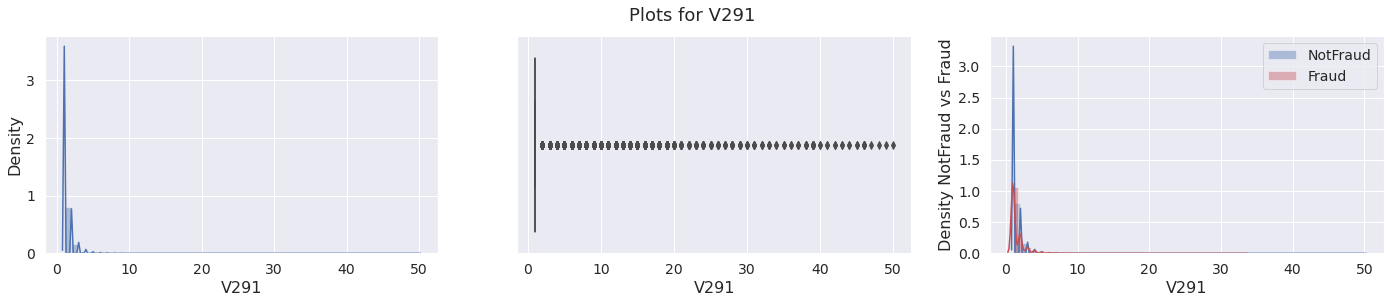

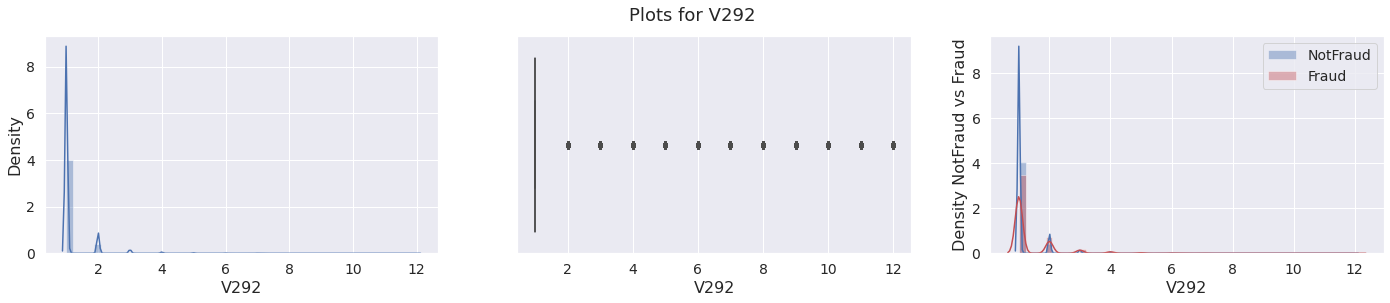

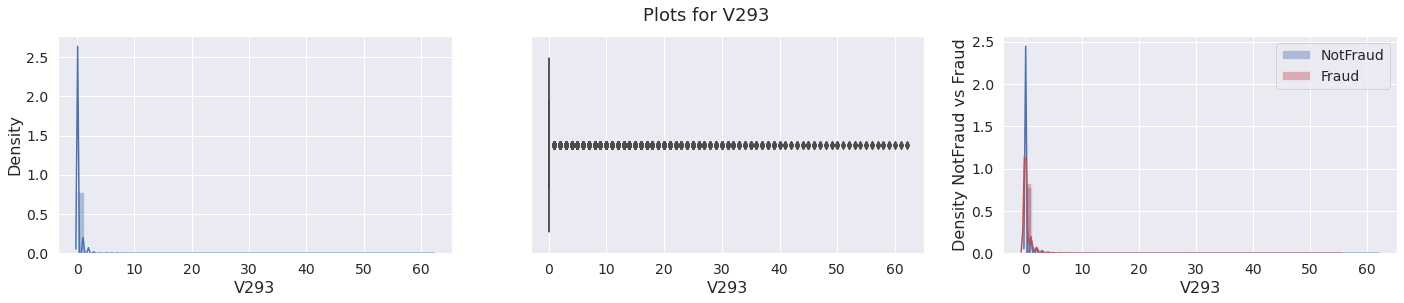

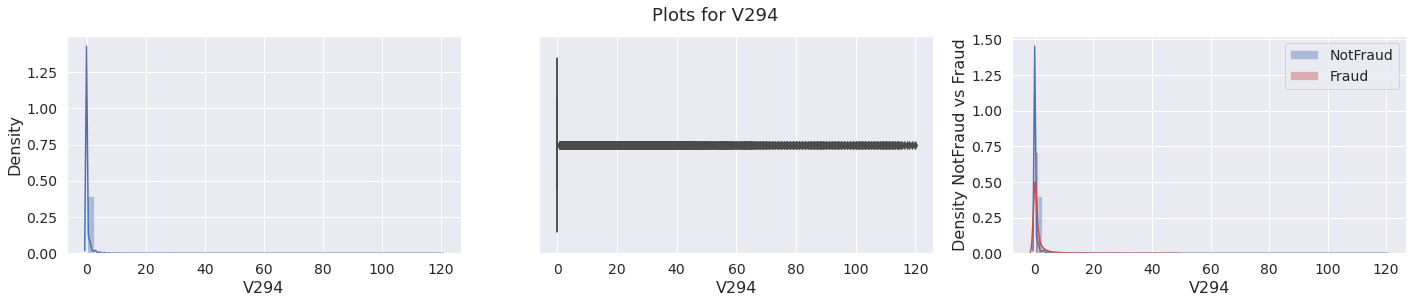

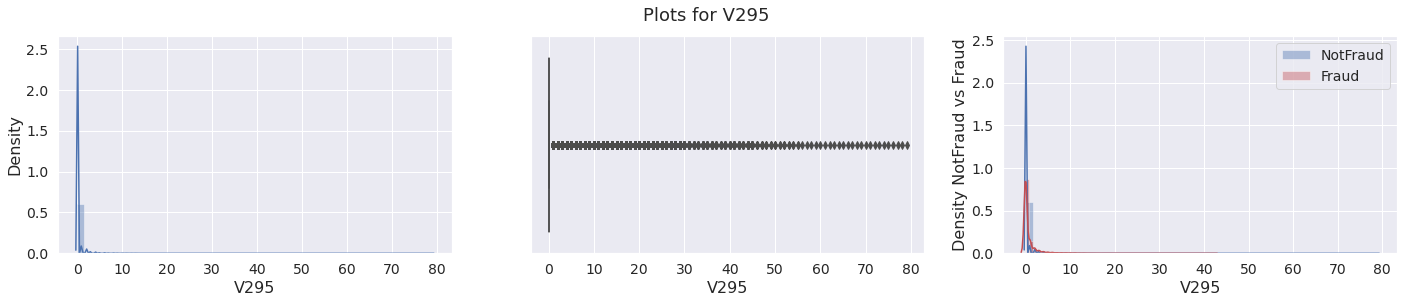

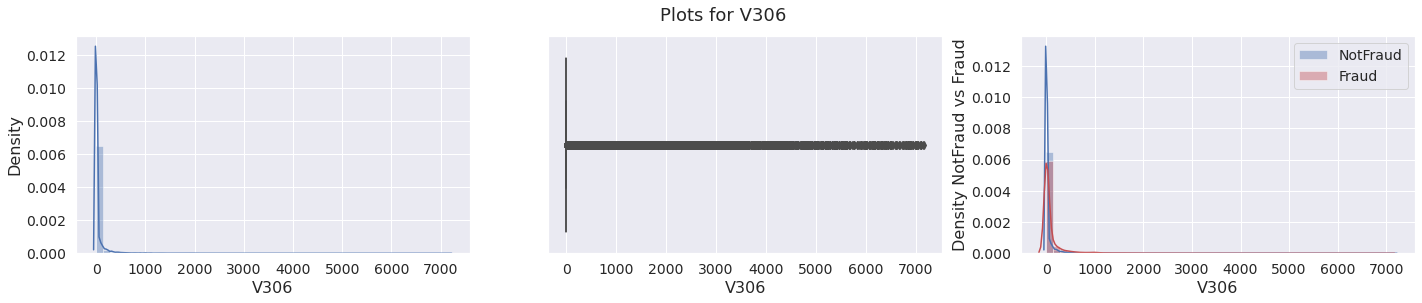

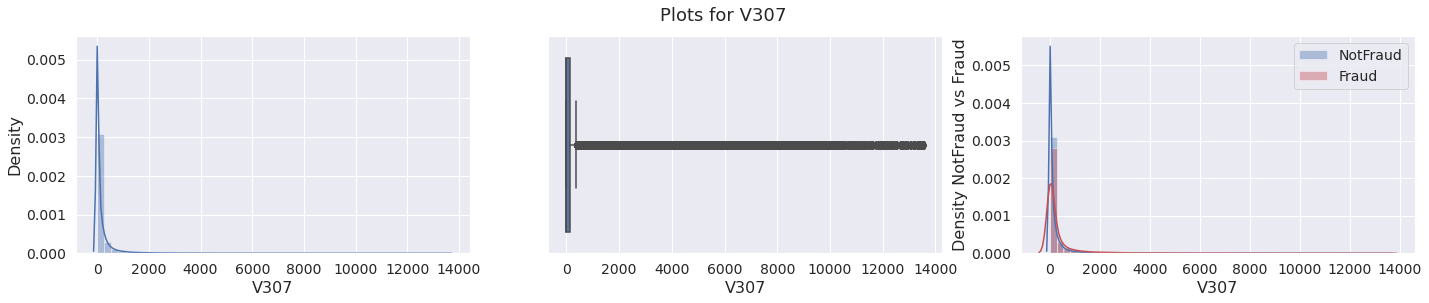

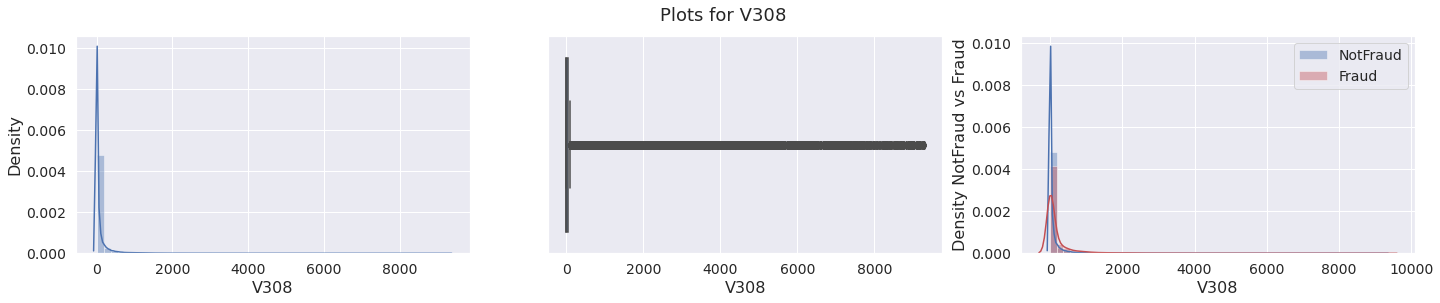

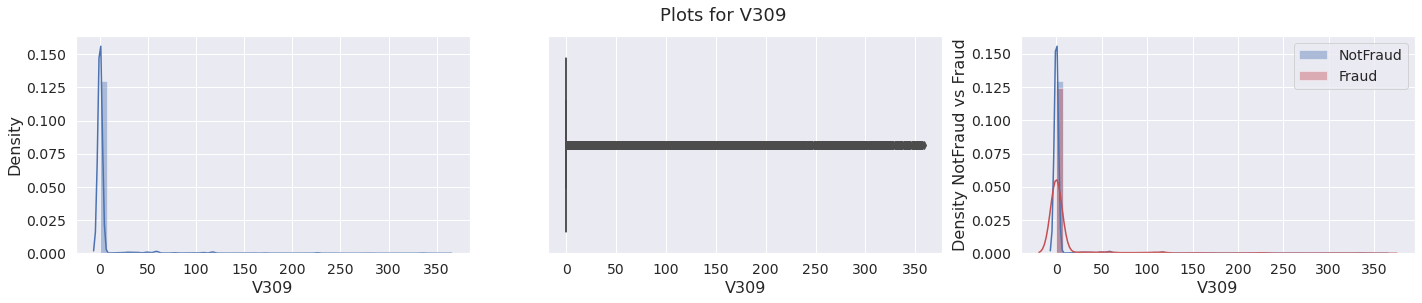

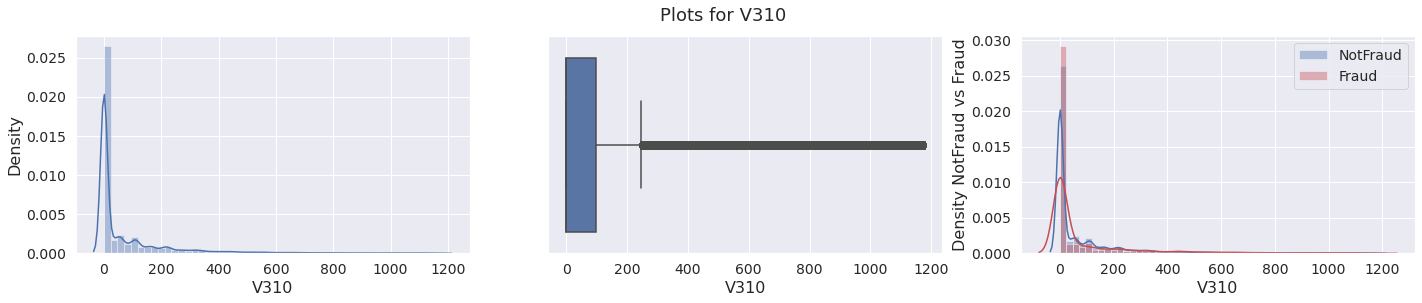

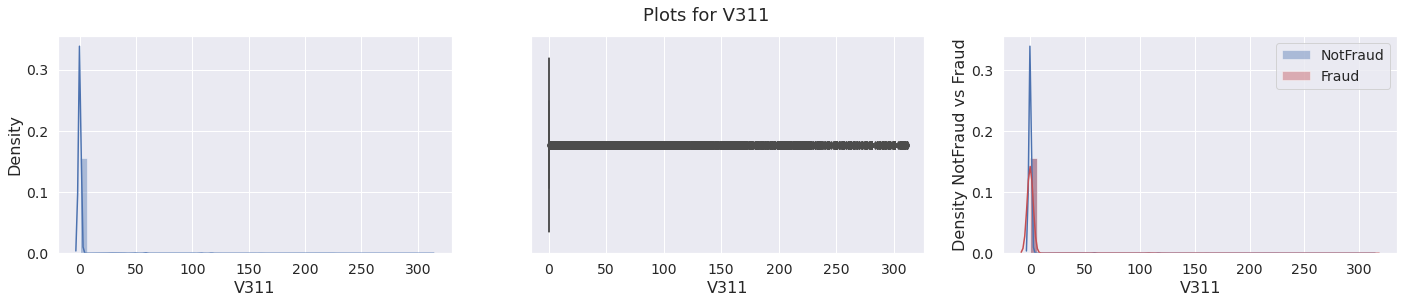

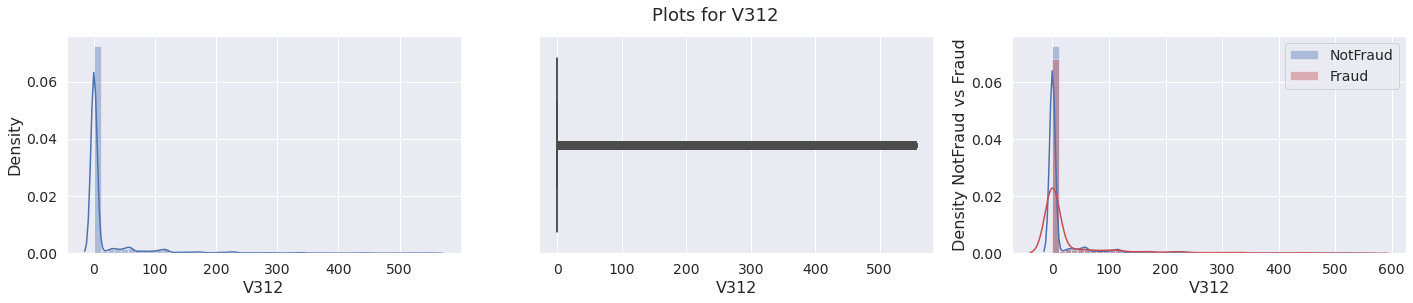

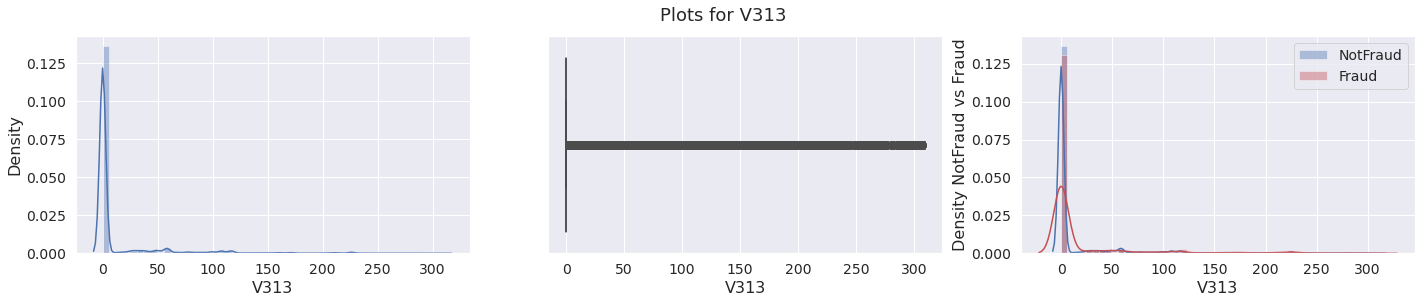

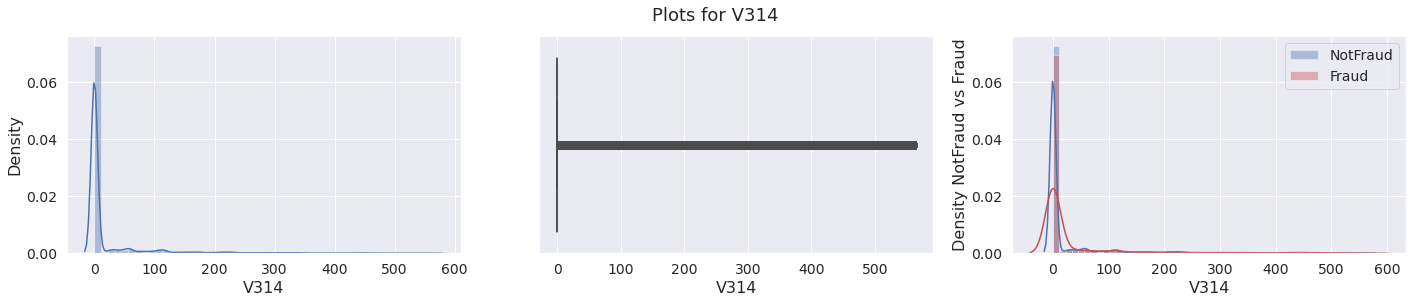

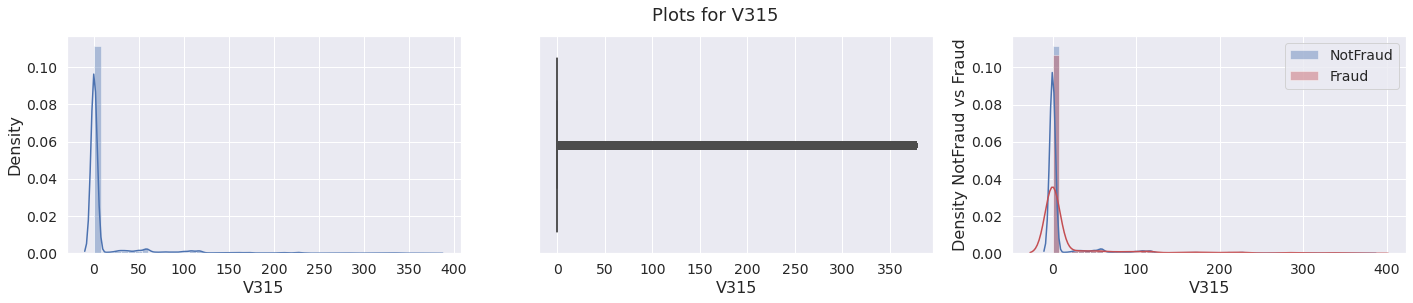

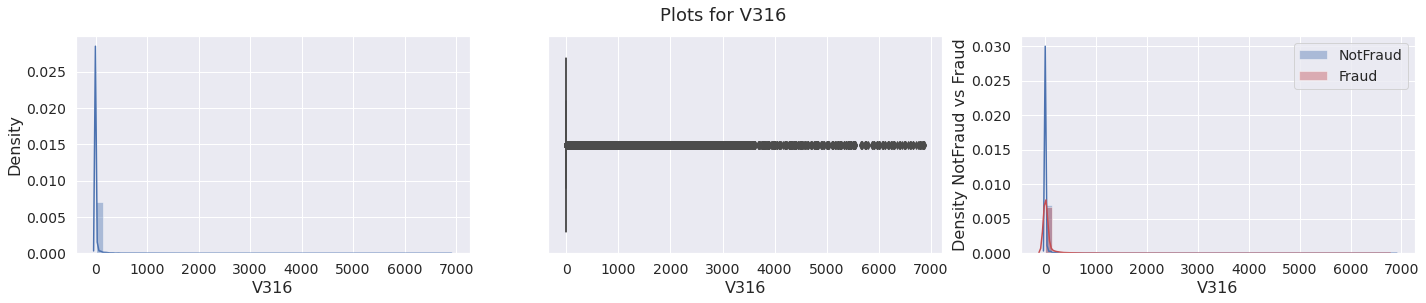

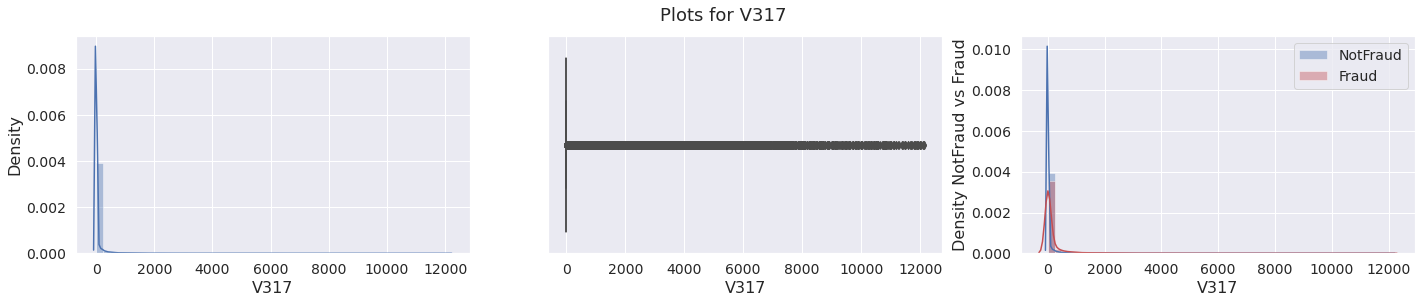

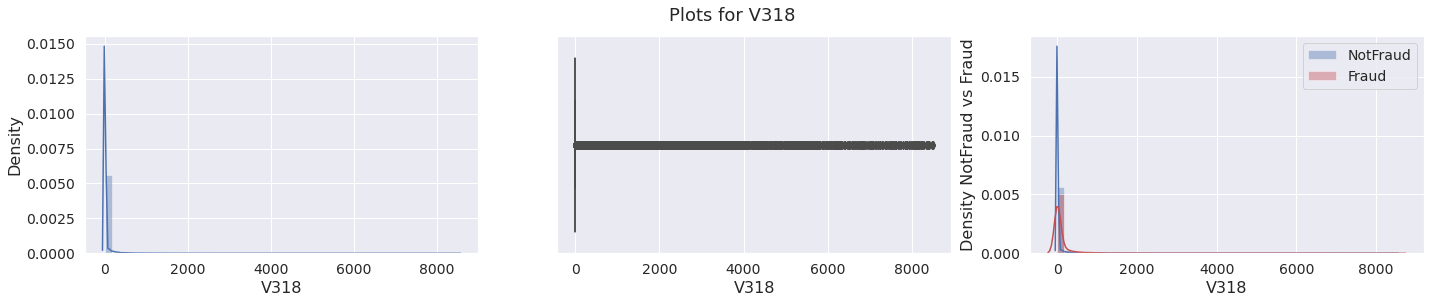

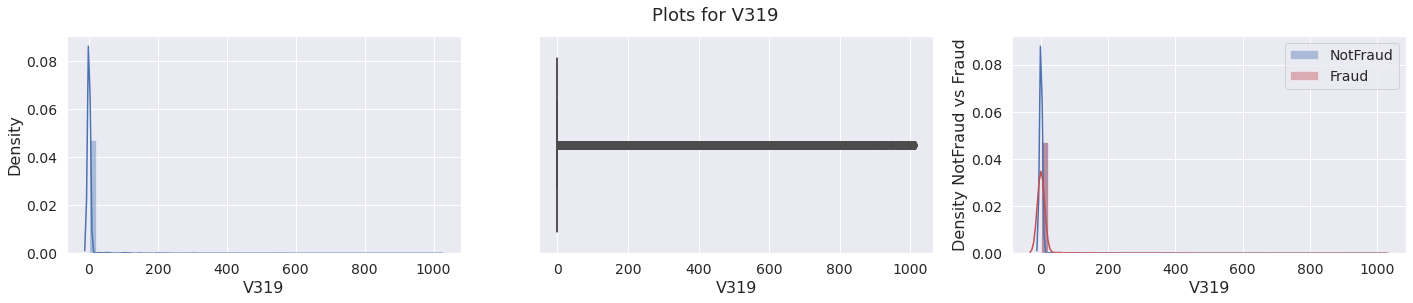

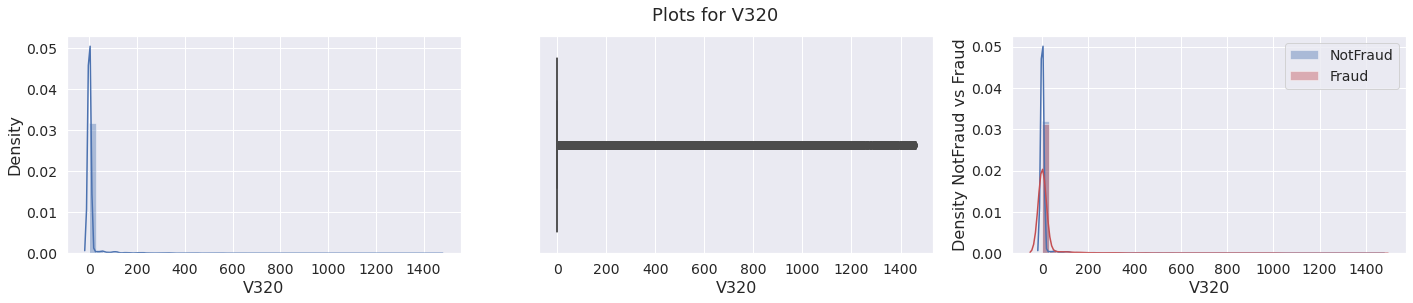

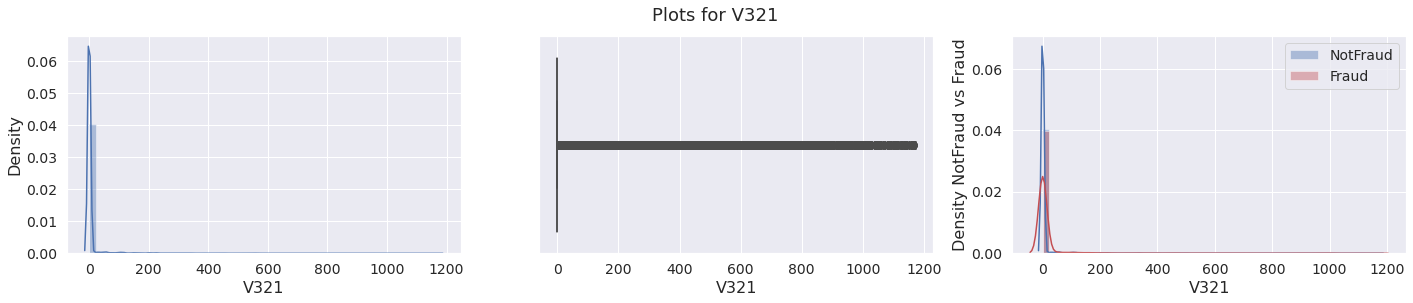

In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

if SHOW_GRAPHS:
    for col in num_cols_filtered.index.tolist():  
       plot_numeric_data(df= train, col= col, target_col = TARGET, remove_outliers = True)

## Data Pre-Processing
* Concatenate the tranining and test dataset by appending . This is done so that we can apply pre-processing steps to combined set.
* Convert the categorcal features from string to int using ordinal encoding. For example convert ['A', 'B'. 'C'] to [1,2,3]
* Create a dataframe sub for submission of test scores, we will later fill it with predictions on test set

In [28]:
# Concatenate the tranining and test dataset by appending
data_all = train.append(test, ignore_index = True, sort=False)

# Do ordinal encoding for categorical features
for col in cat_cols:
    data_all[col], uniques = pd.factorize(data_all[col])
    #the factorize sets null values to -1, so convert them back to null, as we want LGB to handle null values
    data_all[col] = data_all[col].replace(-1, np.nan)
    
#Create submission pandas dataframe 
sub = pd.DataFrame()
sub['TransactionID'] = test.TransactionID

# free the memory which is not required as it can exceed the physical ram 
del train, test
gc.collect()


35011

## Create Test, Train and Validation sets
* From combined dataset split the training and test datasets and seperate the target and features
* Split the training set into training and validation set. We will use first 80% of data as training set and last 20% as validation set.
* Since the data is sorted in time according to transaction timestamp, we should not use random split.

In [29]:
from sklearn.model_selection import train_test_split

#For test set target value will be null
X_train =  data_all[data_all[TARGET].notnull()]
X_test  =  data_all[data_all[TARGET].isnull()]
del data_all
gc.collect()

#get the labels for traning set
y_train = X_train[TARGET]

# Remove ID and TARGET column from train and test set
X_train = X_train.drop(['TransactionID', TARGET], axis = 1)
X_test = X_test.drop(['TransactionID',   TARGET], axis = 1)

# Split the training set into training and validation set. 
# We will use first 80% of data as traningg set and last 20% as validation set.
# Since the data is sorted in time according to transaction timestamp, we should not use random split.
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, shuffle=False, 
                                                      random_state = RANDOM_STATE)

print('Train shape{} Valid Shape{}, Test Shape {}'.format(X_train.shape, X_valid.shape, X_test.shape))

Train shape(472432, 432) Valid Shape(118108, 432), Test Shape (506691, 432)


## Train LightGBM Model
* LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient https://lightgbm.readthedocs.io/en/latest/Features.html
* Train on first 80% of dataset and evaluate on next 20 % as data is sorted in time
* Set 'is_unbalance' = True to handle the unbalanced nature of dataset
* Set categorical_feature parameter with list  of categorical columns. LightGBM can handle them efficiently without need to to one-hot-encoding
* No imputation of missing values is necessary as LightGBM can use optimized strategies automatically
* This is basic model, no feature selection or feature engineering would be done. We will train using all features

In [30]:
%%time
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid  = lgb.Dataset(X_valid, y_valid)
early_stopping_rounds = 200
lgb_results = {}

params = {}

params['learning_rate'] = 0.06
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['seed'] =  RANDOM_STATE
params['metric'] =    'auc'
params['is_unbalance'] = True
params['bagging_fraction'] = 0.8
params['bagging_freq'] = 1
params['feature_fraction'] = 0.8
params['max_bin'] = 127

model = lgb.train(params,
                  lgb_train,
                  num_boost_round = 10000,
                  valid_sets =  [lgb_train,lgb_valid],
                  early_stopping_rounds = early_stopping_rounds,                    
                  categorical_feature = cat_cols,
                  evals_result = lgb_results,
                  verbose_eval = 100
                   )


y_pred_test = model.predict(X_test)
sub['isFraud'] = y_pred_test
sub.to_csv('lgb_sub.csv', index=False)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['DeviceInfo', 'DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.976684	valid_1's auc: 0.904472
[200]	training's auc: 0.987694	valid_1's auc: 0.906191
[300]	training's auc: 0.992432	valid_1's auc: 0.906366
[400]	training's auc: 0.994904	valid_1's auc: 0.905059
Early stopping, best iteration is:
[231]	training's auc: 0.989476	valid_1's auc: 0.906928
CPU times: user 19min 3s, sys: 9.82 s, total: 19min 13s
Wall time: 5min 8s


## Display Results

In [31]:
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, precision_score, recall_score,confusion_matrix

def validation_results(y_valid, y_prob, verbose = True):   
    scores = {}                      
    y_pred_class =  [0  if x < 0.5 else 1 for x in y_prob]
    scores['val_accuracy']  = accuracy_score(y_valid, y_pred_class)
    scores['val_auc']       = roc_auc_score(y_valid, y_prob)
    scores['val_f1']        =   f1_score(y_valid, y_pred_class, average = 'binary')
    scores['val_precision'] = precision_score(y_valid, y_pred_class)
    scores['val_recall']    = recall_score(y_valid, y_pred_class)
    
    cm = confusion_matrix(y_valid, y_pred_class)
    cm_df = pd.DataFrame(cm, columns=np.unique(y_valid), index = np.unique(y_valid))
    if verbose:
        print('\nValidation Accuracy      {:0.5f}'.format( scores['val_accuracy'] ))
        print('Validation   AUC         {:0.5f}'.format( scores['val_auc']   ))
        print('Validation Precision     {:0.5f}'.format(scores['val_precision']))
        print('Validation Recall        {:0.5f}'.format(scores['val_recall']))
        print('Validation  F1           %0.5f' %scores['val_f1'] )
    return scores , cm_df

In [32]:
y_prob = model.predict(X_valid)
results, cm_df  = validation_results(y_valid, y_prob, verbose = True)



Validation Accuracy      0.92365
Validation   AUC         0.90693
Validation Precision     0.26497
Validation Recall        0.68701
Validation  F1           0.38244


### Display Confusion Matrix

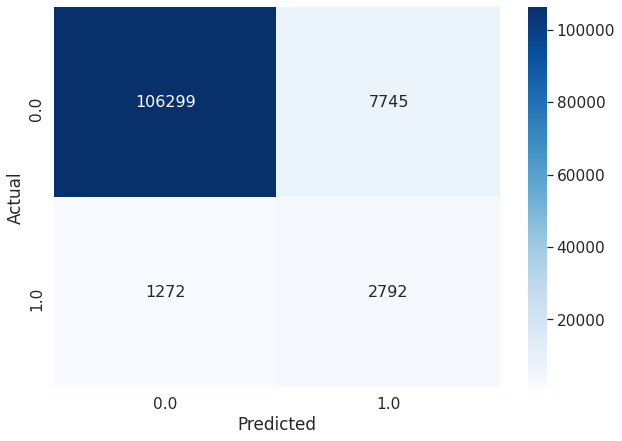

In [33]:

cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_df, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size
plt.show()

### Display Training vs Validation scores

In [34]:

def plot_lgb_scores(lgb_results):
    train_res = lgb_results['training']['auc']
    valid_res = lgb_results['valid_1']['auc']
    ntrees = range(1, len(train_res) + 1)

    plt.figure(figsize = (12, 6))
    plt.plot(ntrees, train_res , 'b', label = 'Training')
    plt.plot(ntrees, valid_res, 'r', label = 'Validation')
    plt.xlabel('Number of Trees', fontsize = 14)
    plt.ylabel('AUC Score', fontsize = 14)
    plt.legend(fontsize = 14)
    plt.show()
    

    


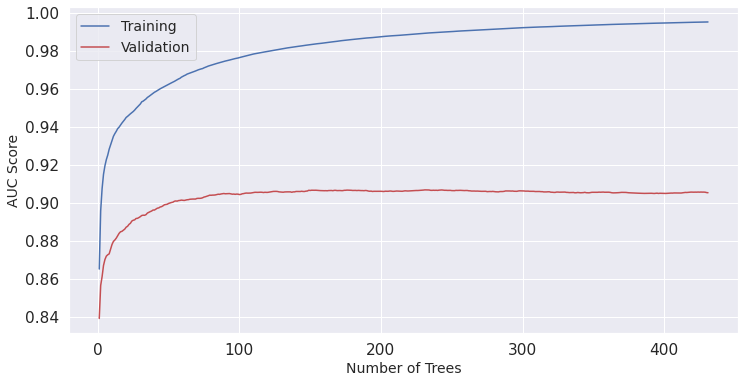

In [35]:
plot_lgb_scores(lgb_results)

### Plot Feature Importance
Display top 20 features 

In [36]:
def plot_feature_imp(model, top_n = 30):
    feature_imp = pd.DataFrame()
    feature_imp['feature'] = model.feature_name()
    feature_imp['importance']  = model.feature_importance()
    feature_imp = feature_imp.sort_values(['importance'], ascending = False)
    feature_imp_disp = feature_imp.head(top_n)
    plt.figure(figsize=(10, 12))
    sns.barplot(x="importance", y="feature", data=feature_imp_disp)
    plt.title('LightGBM Features')
    plt.show() 
#     return feature_imp

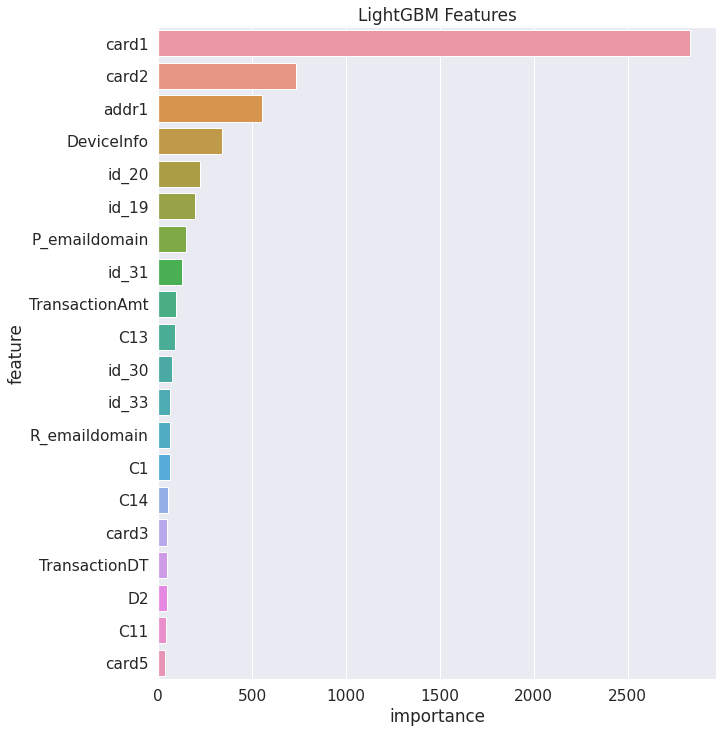

In [37]:
plot_feature_imp(model, top_n = 20)

### Predict on Test Set 
Also write the results as csv file

In [38]:
y_prob_test = model.predict(X_test)
sub['isFraud'] = y_prob_test
sub.to_csv('lgb_sub.csv', index=False)
sub.head()

TransactionID   isFraud
0        3663549  0.009608
1        3663550  0.010820
2        3663551  0.034946
3        3663552  0.000574
4        3663553  0.018270

## Summary
* Perform EDA for numeric and categorical features.
* Do basic data preprocessing steps to convert categorical variables to integers using ordinal encoding.
* Train on a LightGBM model with 80% data and 20% validation data without any feature engineering using all features.
* Use metric AUC to evaluate the performance of model.
* Our basic models achieved AUC of 0.906929 on public test and AUC of  0.882078 on private test.
